In [131]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gym
from tqdm import tqdm
from hiive.mdptoolbox import example, mdp
import random
from time import time

random.seed(2)

# Problem 1 - Frozen Lake

In [132]:
TERM_STATE_MAP = {"4x4": [5, 7, 11, 12], "8x8": [19, 29, 35, 42, 46, 52, 54, 59], "20x20":[5, 13, 19, 29, 35, 42, 46, 52, 69, 72, 83, 101, 120, 144, 159, 237, 306, 345, 368, 390]}
GOAL_STATE_MAP = {"4x4": [15], "8x8": [63], "20x20":[399]}

MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
    "20x20": [
        "SFFFFFFHHHFFFFFFFFFF",
        "FFFFFFFFFFFFFFFFHHFF",
        "FFFHFFFFFFFHHFFFFFFF",
        "FFFFFHFFFFFFFFFFHHFF",
        "FFFFFHFFFFFFFFFFHHFF",
        "FFFFFHFFFFFFFFFFHHFF",
        "FFFFFFFFHFFFFFFFHHFF",
        "FFFFFHFFFFHHFFFFHHFF",
        "FFFFFHFFFFFFFFFFHHFF",
        "FFFFFHFFFFFFFFFFHHFF",
        "FFFFFFFFFFFHHHHHHHFF",
        "HHHHFHFFFFFFFFFFHHFF",
        "FFFFFHFFFFHHHFFFHHFF",
        "FFFFFFFFFFFFFFFFHHFF",
        "FFFFFHFFFFFFHFFFHHFF",
        "FFFFFHFFFFFFFFFFHHFF",
        "FFFFFFFFFFFHFFFFFFFF",
        "FHHFFFHFFFFHFFFFFHFF",
        "FHHFHFHFFFFFFFFFFFFF",
        "FFFHFFFFFHFFFFHHFHFG"
    ]
}
cmap = 'BuGn'

def visualize_env(env, name, title=None):
    shape = env.desc.shape
    M = shape[0]
    N = shape[1]
    arr = np.zeros(shape)
    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[name]:
                arr[i, j] = 0.25
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                arr[i, j] = 1.0
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(arr, cmap=cmap)
    ax.set_xticks(np.arange(M))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(M))
    ax.set_yticklabels(np.arange(N))
    ax.set_xticks(np.arange(-0.5, M, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.grid(False)
    ax.grid(which='minor', color='w', linewidth=2)

    for i in range(M):
        for j in range(N):
            if (i, j) == (0, 0):
                ax.text(j, i, 'S', ha='center', va='center', color='k', size=18)
            elif (N * i + j) in TERM_STATE_MAP[name]:
                ax.text(j, i, 'H', ha='center', va='center', color='k', size=18)
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                ax.text(j, i, 'G', ha='center', va='center', color='k', size=18)
            else:
                ax.text(j, i, 'F', ha='center', va='center', color='k', size=18)
    fig.tight_layout()
    if title:
        ax.set_title(title)
    plt.show()

def visualize_policy(policy, shape, name, title=None):
    M = shape[0]
    N = shape[1]
    actions = np.asarray(policy).reshape(shape)
    mapping = {
        0: '←',
        1: '↓',
        2: '→',
        3: '↑'
    }
    arr = np.zeros(shape)
    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[name]:
                arr[i, j] = 0.25
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                arr[i, j] = 1.0
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(arr, cmap=cmap)
    ax.set_xticks(np.arange(M))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(M))
    ax.set_yticklabels(np.arange(N))
    ax.set_xticks(np.arange(-0.5, M, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.grid(False)
    ax.grid(which='minor', color='w', linewidth=2)

    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[name]:
                ax.text(j, i, 'H', ha='center', va='center', color='k', size=18)
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                ax.text(j, i, 'G', ha='center', va='center', color='k', size=18)
            else:
                ax.text(j, i, mapping[actions[i, j]], ha='center', va='center', color='k', size=18)
    # fig.tight_layout()
    if title:
        ax.set_title(title)
    plt.show()

def visualize_value(V, shape, name, title=None):
    V = np.asarray(V)
    M = shape[0]
    N = shape[1]
    fig, ax = plt.subplots(figsize=(12,12))
    arr = V.reshape(shape)
    im = ax.imshow(arr, cmap=cmap)
    ax.set_xticks(np.arange(M))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(M))
    ax.set_yticklabels(np.arange(N))
    ax.set_xticks(np.arange(-0.5, M, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.grid(False)
    ax.grid(which='minor', color='w', linewidth=2)
    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[name]:
                ax.text(j, i, 'H', ha='center', va='center', color='k')
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                ax.text(j, i, 'G', ha='center', va='center', color='k')
            else:
                ax.text(j, i, '%.2f' % (arr[i, j]), ha='center', va='center', color='k')
    # fig.tight_layout()
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('State-value estimate', rotation=-90, va="bottom")
    if title:
        ax.set_title(title)
    plt.show()

In [133]:
def getRewardProb(env, sz):
    sz = int(sz**2)
    r = np.zeros((4,sz,sz))
    p = np.zeros((4,sz,sz))
    envP = env.unwrapped.P
    for state in envP:
        for action in envP[state]:
            transitions = envP[state][action]
            for t_idx in range((len(transitions))):
                new_state = transitions[t_idx][1]
                trans_prob = transitions[t_idx][0]
                reward = transitions[t_idx][2]
                p[action][state][new_state] += trans_prob
                r[action][state][new_state] += reward
            p[action,state,:] /= np.sum(p[action,state,:])
    return r, p

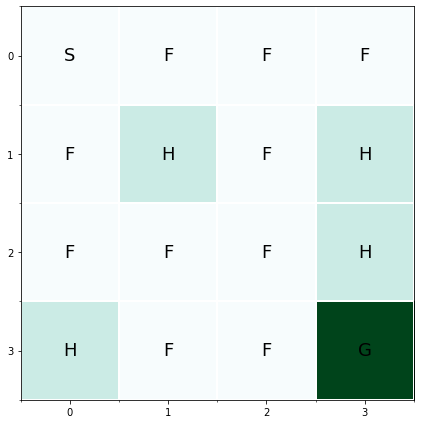

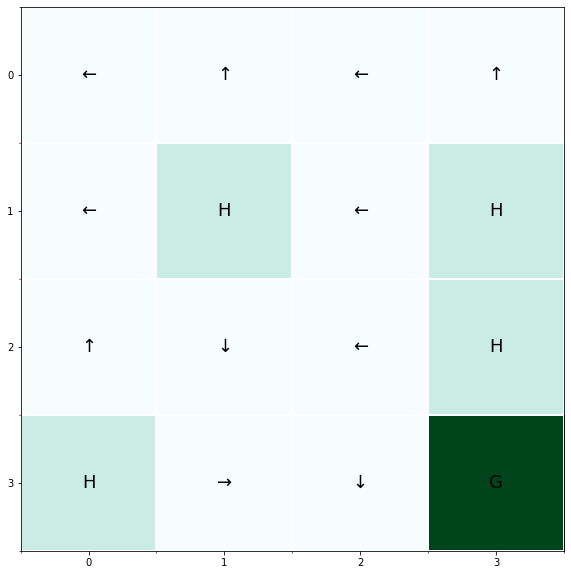

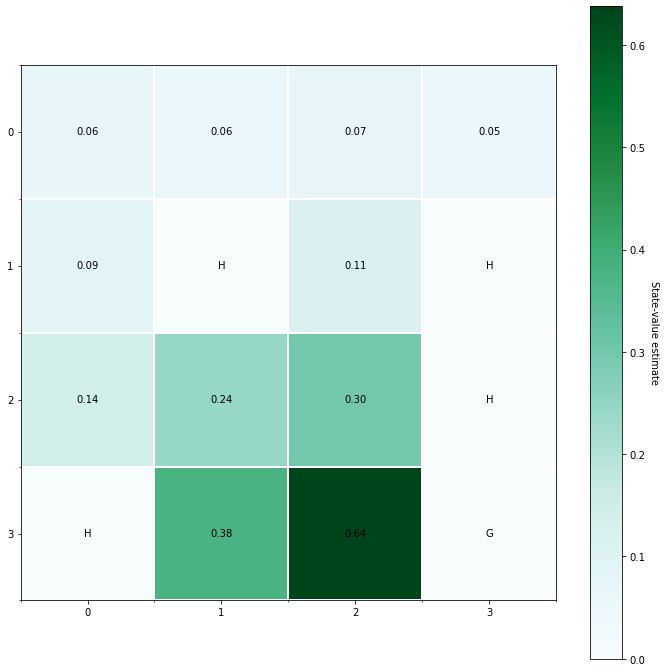

(0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)
(0.06162274283994246, 0.05531399137342944, 0.06996222441595021, 0.05101702913301784, 0.0851946143178323, 0.0, 0.10976851693787402, 0.0, 0.13996615432409334, 0.24373109529624212, 0.29696299492872447, 0.0, 0.0, 0.37715398384339976, 0.6375395830635081, 0.0)


In [84]:
s = 4
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v1", map_name=None, desc=MAPS[opt])
env.reset()
visualize_env(env, opt)
r, p = getRewardProb(env, s)
vi = mdp.ValueIteration(p, r, 0.9, max_iter=10000)
vi.run()
visualize_policy(vi.policy, sz, opt)
visualize_value(vi.V, sz, opt)
print(vi.policy)
print(vi.V)

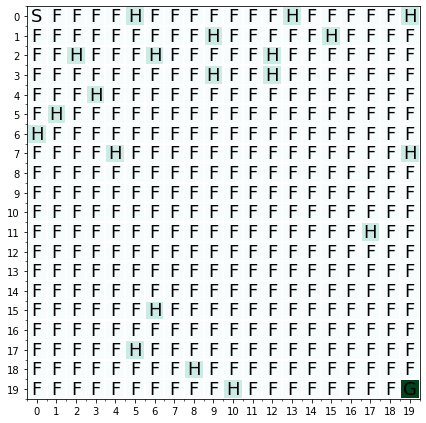

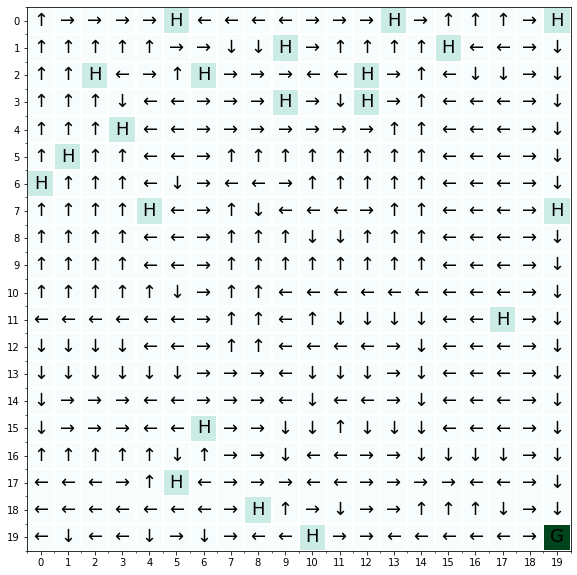

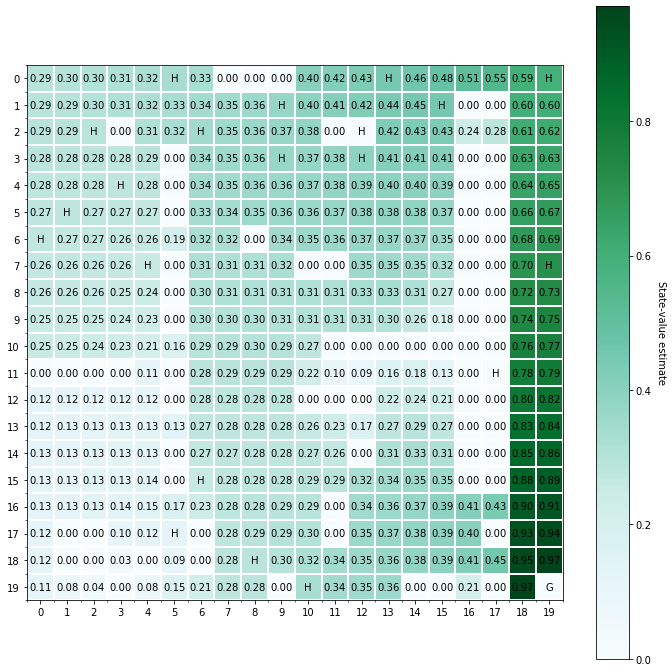

(3, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 2, 1, 1, 1, 2, 3, 3, 3, 3, 0, 0, 0, 2, 1, 3, 3, 0, 0, 2, 3, 2, 2, 2, 2, 0, 0, 0, 2, 3, 0, 1, 1, 2, 1, 3, 3, 3, 1, 0, 0, 2, 2, 2, 2, 2, 1, 1, 2, 3, 0, 0, 0, 2, 1, 3, 3, 3, 3, 0, 0, 2, 2, 2, 2, 2, 2, 2, 3, 3, 0, 0, 0, 2, 1, 3, 3, 3, 3, 0, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 2, 1, 3, 3, 3, 3, 0, 1, 2, 0, 0, 2, 3, 3, 3, 3, 3, 0, 0, 0, 2, 1, 3, 3, 3, 3, 0, 0, 2, 3, 1, 0, 0, 0, 2, 3, 3, 0, 0, 0, 2, 1, 3, 3, 3, 3, 0, 0, 2, 3, 3, 3, 1, 1, 3, 3, 3, 0, 0, 0, 2, 1, 3, 3, 3, 3, 0, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 2, 1, 3, 3, 3, 3, 3, 1, 2, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 3, 1, 1, 1, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 0, 0, 2, 3, 3, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 2, 1, 0, 0, 0, 2, 1, 1, 2, 2, 2, 0, 0, 2, 2, 2, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 2, 2, 2, 0, 0, 2, 2, 2, 1, 1, 3, 1, 1, 1, 0, 0, 0, 2, 1, 3, 3, 3, 3, 3, 1, 3, 2, 2, 1, 0, 0, 2, 

In [39]:
s = 20
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v1", map_name=None, desc=MAPS[opt])
env.reset()
visualize_env(env, opt)
r, p = getRewardProb(env, s)
vi = mdp.ValueIteration(p, r, 0.995, max_iter=10000)
vi.run()
visualize_policy(vi.policy, sz, opt)
visualize_value(vi.V, sz, opt)
print(vi.policy)
print(vi.V)

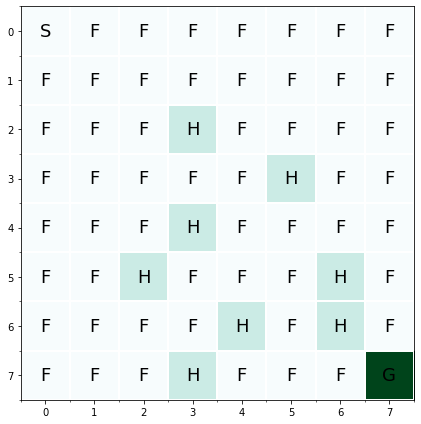

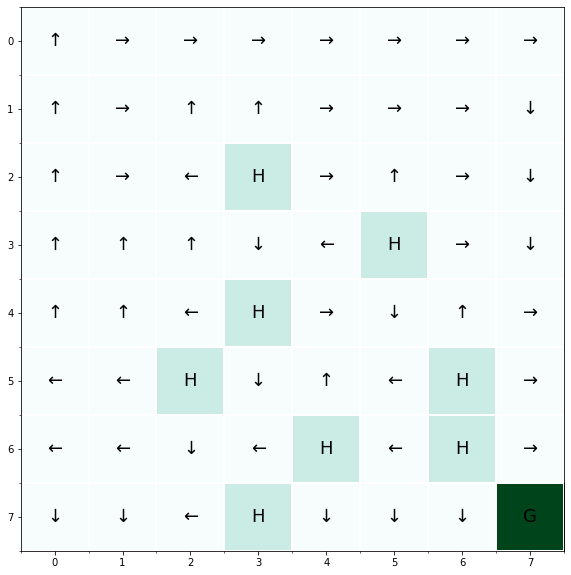

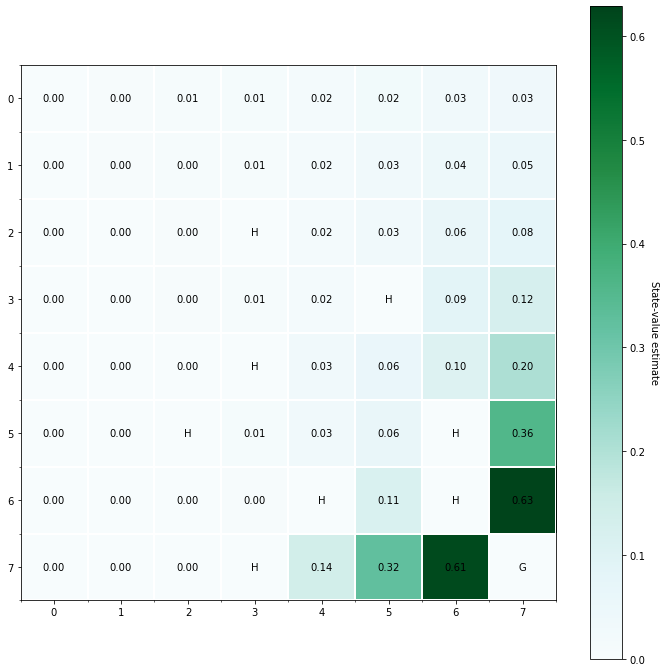

(3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 1, 3, 2, 0, 0, 2, 3, 2, 1, 3, 3, 3, 1, 0, 0, 2, 1, 3, 3, 0, 0, 2, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 0, 0, 1, 1, 1, 0)
(0.0016222239566742473, 0.003060767917967338, 0.005794696120726524, 0.010391772523762477, 0.017096445085483743, 0.024184217897011896, 0.031305405198300065, 0.034807000637929984, 0.0014614164657766957, 0.0025998234270686914, 0.00491158820225451, 0.009528857060098674, 0.018569242048914848, 0.02824681107297098, 0.04145082033811706, 0.04961360828623488, 0.00110767183800537, 0.0017479003053684666, 0.002534743663058876, 0.0, 0.019251888940225094, 0.031535518612617976, 0.06038509407787975, 0.07740832679314802, 0.0008892444937213366, 0.0014289582948647493, 0.0026514428762168386, 0.005501707812890226, 0.016324897609164078, 0.0, 0.08538043726900817, 0.12312206063017188, 0.0005936070916375847, 0.0007957864730272987, 0.0009520707606779981, 0.0, 0.03105538035855836, 0.058199567021159915, 0.10375840184356261, 

In [40]:
s = 8
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v1", map_name=opt)
env.reset()
env.render()
visualize_env(env, opt)
r, p = getRewardProb(env, s)
vi = mdp.ValueIteration(p, r, 0.9, max_iter=10000)
vi.run()
visualize_policy(vi.policy, sz, opt)
visualize_value(vi.V, sz, opt)
print(vi.policy)
print(vi.V)

## 1. Value Iteration

In [41]:
def valueIterateGraph(p, r, value_iterate=True):
    max_vs = []
    mean_vs = []
    errors = []
    rewards = []
    times = []
    iterations = []
    gammas = list(np.arange(0.5,1,0.04))
    print(gammas)
    for gamma in gammas:
        if value_iterate:
            vi = mdp.ValueIteration(p, r, gamma)
        else:
            vi = mdp.PolicyIteration(p, r, gamma, max_iter=50)
        vi.run()
        vi.run_stats
        iterations.append(list(range(1,len(vi.run_stats)+1)))
        max_vs.append([el['Max V'] for el in vi.run_stats])
        mean_vs.append([el['Mean V'] for el in vi.run_stats])
        errors.append([el['Error'] for el in vi.run_stats])
        rewards.append([el['Reward'] for el in vi.run_stats])
        times.append([el['Time'] for el in vi.run_stats])

    f, ax = plt.subplots(3,2, figsize=(20,15))
    ax[0][0].set_title("Max V", fontsize=12)
    for i in range(len(max_vs)):
        ax[0][0].plot(iterations[i], max_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][0].legend()
    ax[0][0].set_xlabel("# Iterations")

    ax[0][1].set_title("Mean V", fontsize=12)
    for i in range(len(mean_vs)):
        ax[0][1].plot(iterations[i], mean_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][1].legend()
    ax[0][1].set_xlabel("# Iterations")

    ax[1][0].set_title("Error", fontsize=12)
    for i in range(len(errors)):
        ax[1][0].plot(iterations[i], errors[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][0].legend()
    ax[1][0].set_xlabel("# Iterations")

    ax[1][1].set_title("Reward", fontsize=12)
    for i in range(len(rewards)):
        ax[1][1].plot(iterations[i], rewards[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][1].legend()
    ax[1][1].set_xlabel("# Iterations")

    ax[2][0].set_title("Times", fontsize=12)
    for i in range(len(times)):
        ax[2][0].plot(iterations[i], times[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[2][0].legend()
    ax[2][0].set_xlabel("# Iterations")
    
    plt.plot()

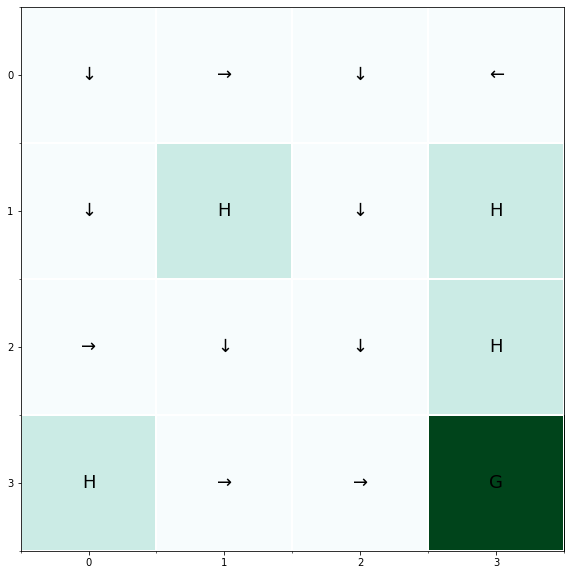

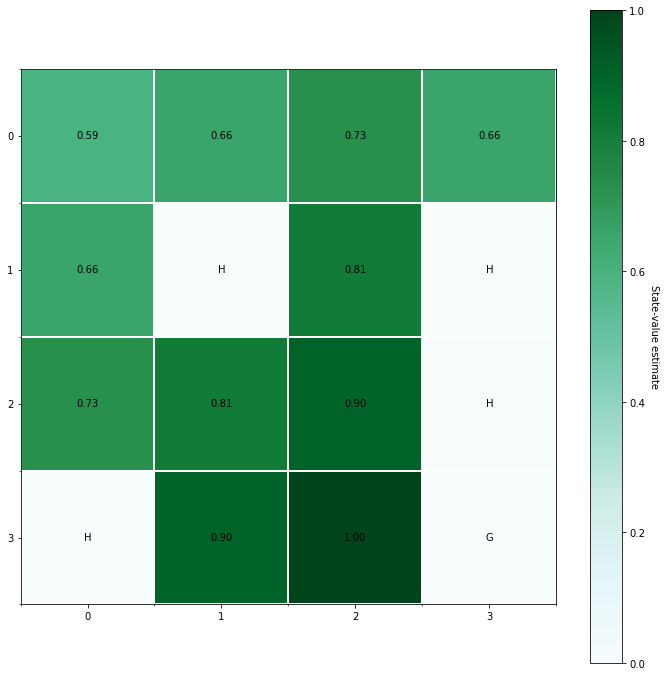

[0.5, 0.54, 0.5800000000000001, 0.6200000000000001, 0.6600000000000001, 0.7000000000000002, 0.7400000000000002, 0.7800000000000002, 0.8200000000000003, 0.8600000000000003, 0.9000000000000004, 0.9400000000000004, 0.9800000000000004]
1.544785737991333


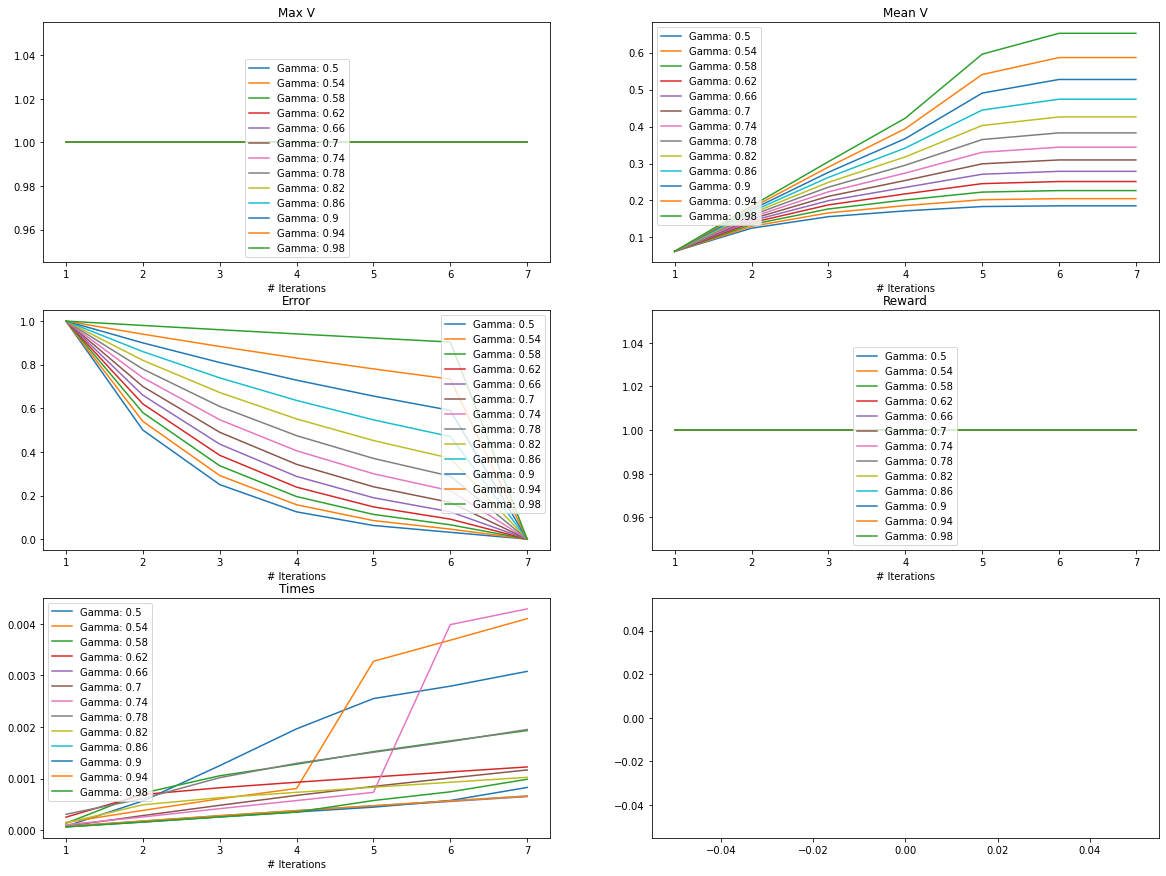

In [44]:
tic = time()
env = gym.make("FrozenLake-v1", is_slippery=False)
r, p = getRewardProb(env,4)
vi = mdp.ValueIteration(p, r, 0.9, max_iter=10000)
vi.run()
visualize_policy(vi.policy, (4,4), "4x4")
visualize_value(vi.V, (4,4), "4x4")
valueIterateGraph(p, r)
print(time()-tic)

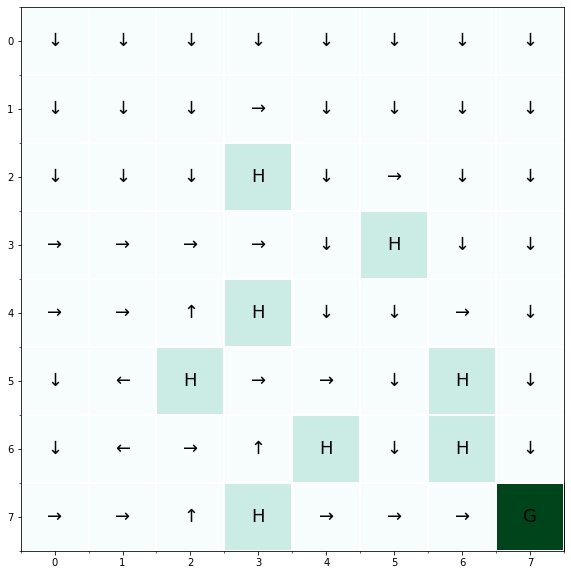

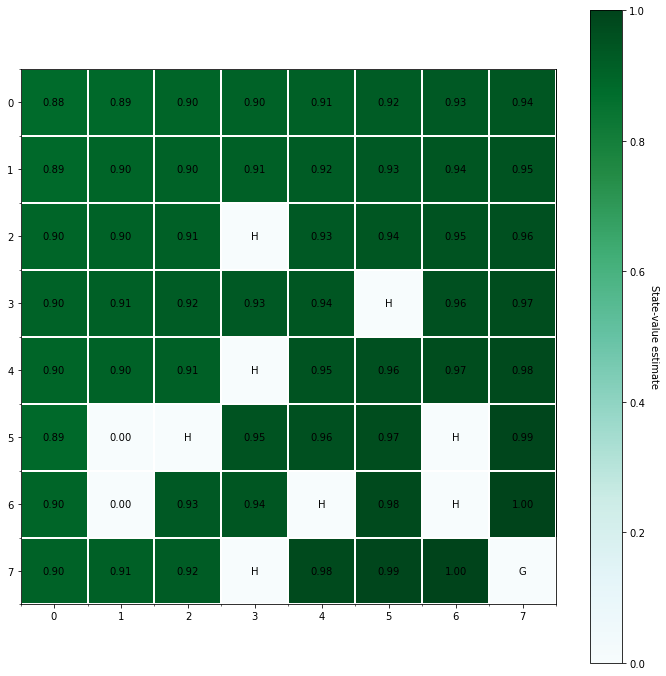

[0.5, 0.54, 0.5800000000000001, 0.6200000000000001, 0.6600000000000001, 0.7000000000000002, 0.7400000000000002, 0.7800000000000002, 0.8200000000000003, 0.8600000000000003, 0.9000000000000004, 0.9400000000000004, 0.9800000000000004]
2.620429039001465


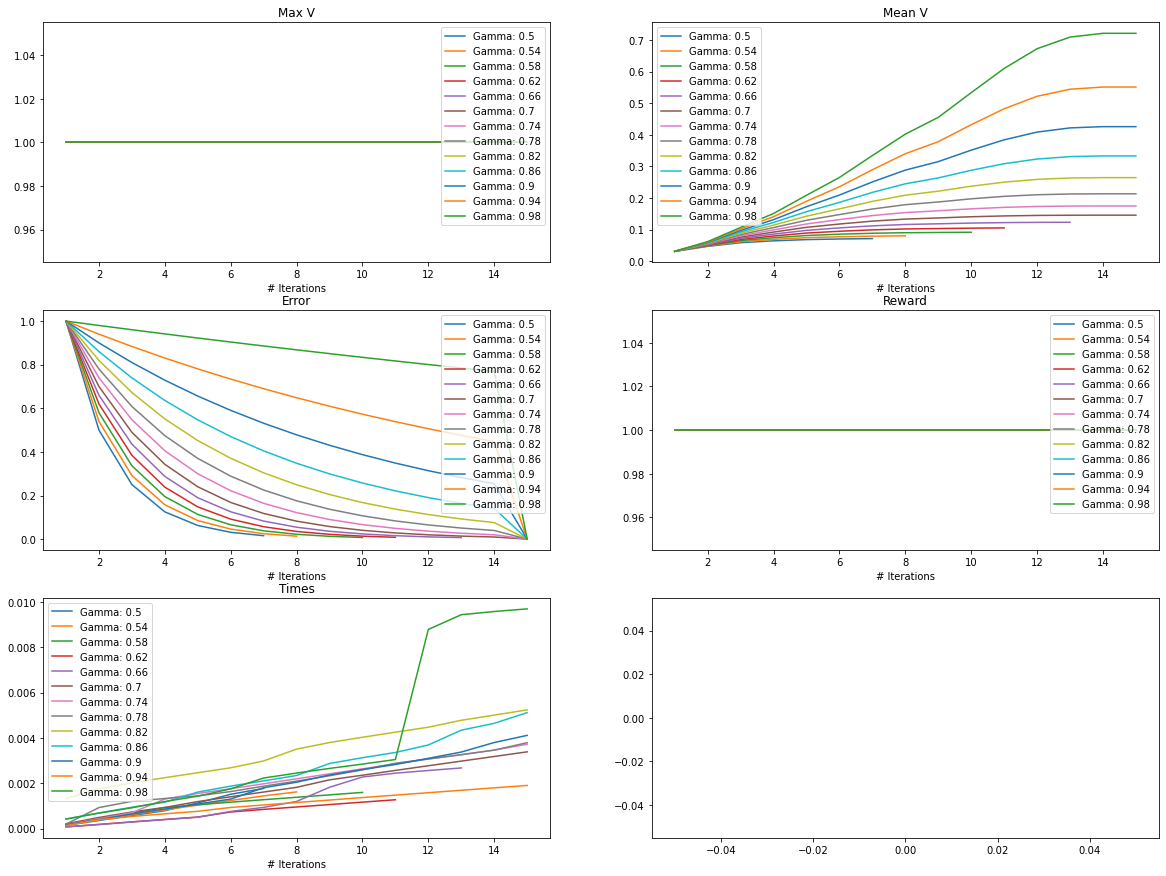

In [46]:
tic = time()
env = gym.make("FrozenLake-v1", is_slippery=False, desc=MAPS["8x8"])
r, p = getRewardProb(env,8)
vi = mdp.ValueIteration(p, r, 0.99, max_iter=10000)
vi.run()
visualize_policy(vi.policy, (8,8), "8x8")
visualize_value(vi.V, (8,8), "8x8")
valueIterateGraph(p, r)
print(time()-tic)

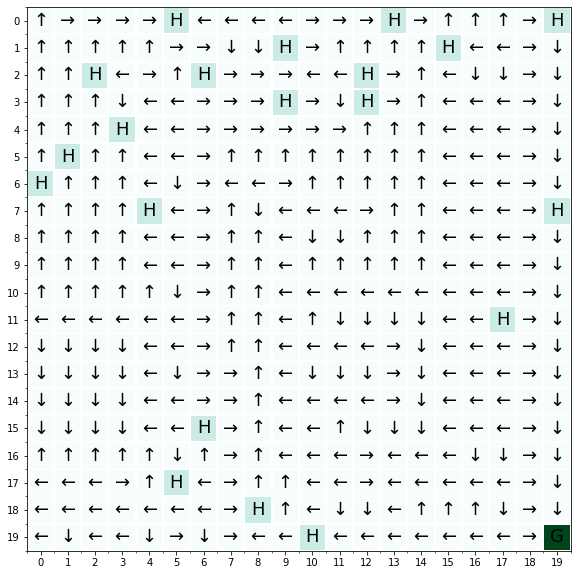

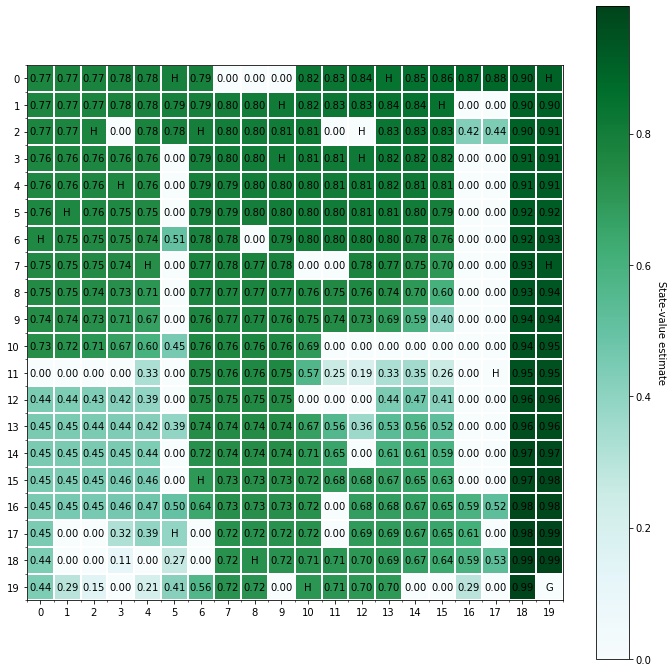

[0.5, 0.54, 0.5800000000000001, 0.6200000000000001, 0.6600000000000001, 0.7000000000000002, 0.7400000000000002, 0.7800000000000002, 0.8200000000000003, 0.8600000000000003, 0.9000000000000004, 0.9400000000000004, 0.9800000000000004]
6.281825065612793


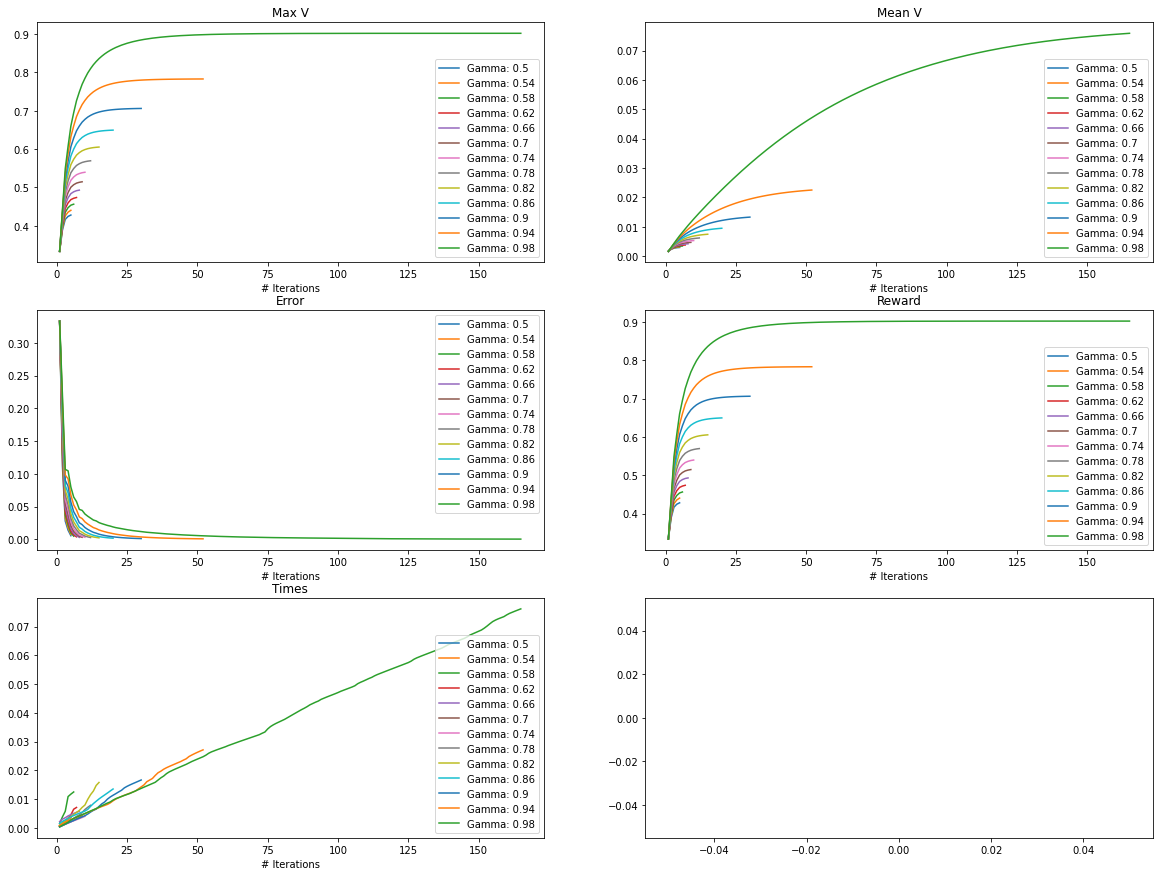

In [88]:
tic = time()
env = gym.make("FrozenLake-v1", is_slippery=True, map_name=None, desc=MAPS["20x20"])
r, p = getRewardProb(env, 20)
vi = mdp.ValueIteration(p, r, 0.999, max_iter=500000)
vi.run()
visualize_policy(vi.policy, (20,20), "20x20")
visualize_value(vi.V, (20,20), "20x20")

valueIterateGraph(p, r)
print(time()-tic)

In [55]:
def runEpisodes(episodes, gamma, sz, max_iter=5000):
    total_rewards = []
    total_successes = 0
    for episode in tqdm(range(episodes)):
        if sz == 8:
            env = gym.make("FrozenLake-v1", is_slippery=True, map_name="8x8")
            env.reset()
            r, p = getRewardProb(env, 8)
        elif sz == 4:
            env = gym.make("FrozenLake-v1", is_slippery=True, map_name="4x4")
            env.reset()
            r, p = getRewardProb(env, 4)
        elif sz == 20:
            env = gym.make("FrozenLake-v1", is_slippery=True, map_name=None, desc=MAPS["20x20"])
            env.reset()
            r, p = getRewardProb(env, 20)
        vi = mdp.ValueIteration(p, r, gamma, max_iter=max_iter)
        vi.run()
        done = False
        state = 0
        policy = vi.policy
        total_reward = 0
        t = 0
        while not (env.desc[state//sz][state%sz]==b'H' or env.desc[state//sz][state%sz]==b'G') and t<3000:
            action = policy[state]
            state, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            if (env.desc[state//sz][state%sz]==b'H' or env.desc[state//sz][state%sz]==b'G'):
                if reward == 1:
                    total_successes += 1
                break
            t += 1
        total_rewards.append(total_reward)
    return total_successes

In [58]:
gammas = [el/100 for el in list(range(1, 100, 1))]
success_rates4 = []
for g in tqdm(gammas):
    total_successes = runEpisodes(episodes = 10, gamma=g, sz=4, max_iter=5000)
    success_rates4.append(np.round(total_successes/episodes, 3))
print(success_rates4)

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 163.31it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 74.26it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 135.22it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 126.43it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 132.11it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 72.17it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 109.25it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 170.20it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 120.36it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 156.47it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 165.91it/s]

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 50.98it/s]

100%|███████████

100%|███████████████████████████████████████████| 99/99 [00:15<00:00,  6.52it/s]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.1, 0.1, 0.1, 0.2, 0.3, 0.3, 0.2, 0.3, 0.2, 0.3, 0.1, 0.2, 0.1, 0.2, 0.1, 0.4, 0.4, 0.2, 0.7, 0.4, 0.4, 0.5, 0.8, 0.5, 0.3, 0.3, 0.6, 0.3, 0.6, 0.1, 0.4, 0.6, 0.4, 0.4, 0.6, 0.4, 0.6, 0.8, 0.7, 0.9, 0.6, 0.8, 0.7, 0.8, 0.9, 0.8, 0.6, 1.0, 0.8, 0.9, 0.8]


In [59]:
gammas = [el/100 for el in list(range(1, 100, 1))]
success_rates8 = []
for g in gammas:
    total_successes = runEpisodes(episodes = 10, gamma=g, sz=8, max_iter=5000)
    success_rates8.append(np.round(total_successes/episodes, 3))
print(success_rates8)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 21.29it/s]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.6, 0.7, 0.6, 0.7, 0.7, 0.5, 0.6, 0.8, 0.9, 0.9, 0.7, 0.7, 0.7, 0.9, 0.8, 0.8, 1.0, 0.8]


In [62]:
gammas20 = [el/1000 for el in list(range(10, 1000, 10))]
success_rates20 = []
for gamma in gammas20:
    episodes = 10
    total_successes = runEpisodes(episodes = episodes, gamma=gamma, sz=20, max_iter=10000)
    success_rates20.append(np.round(total_successes/episodes, 3))
print(success_rates20)

100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.85it/s]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.1, 0.1, 0.3, 0.0, 0.4, 0.1, 0.2, 0.8, 1.0]


Text(0.5, 0, 'Gamma')

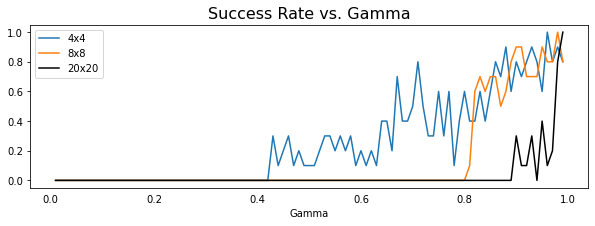

In [67]:
f, ax = plt.subplots(1, figsize=(10,3))
ax.set_title("Success Rate vs. Gamma", fontsize=16)
ax.plot(gammas, success_rates4, label="4x4")
ax.tick_params(bottom=False)
ax.plot(gammas, success_rates8, label="8x8")
ax.plot(gammas20, success_rates20, label="20x20", color='k')
ax.legend()
ax.set_xlabel("Gamma")

## 2. Policy Iteration

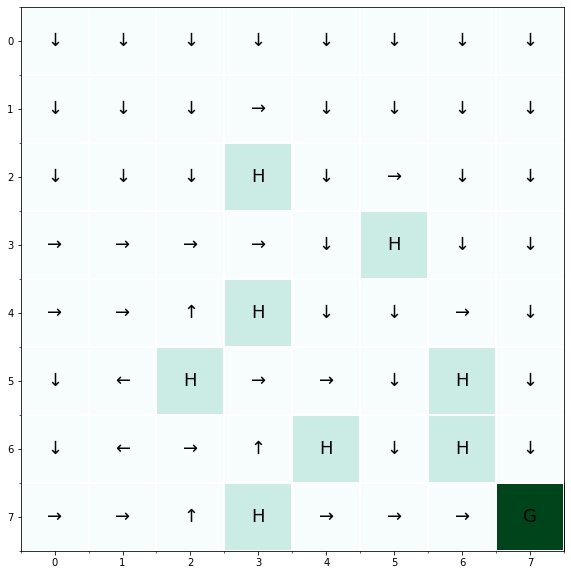

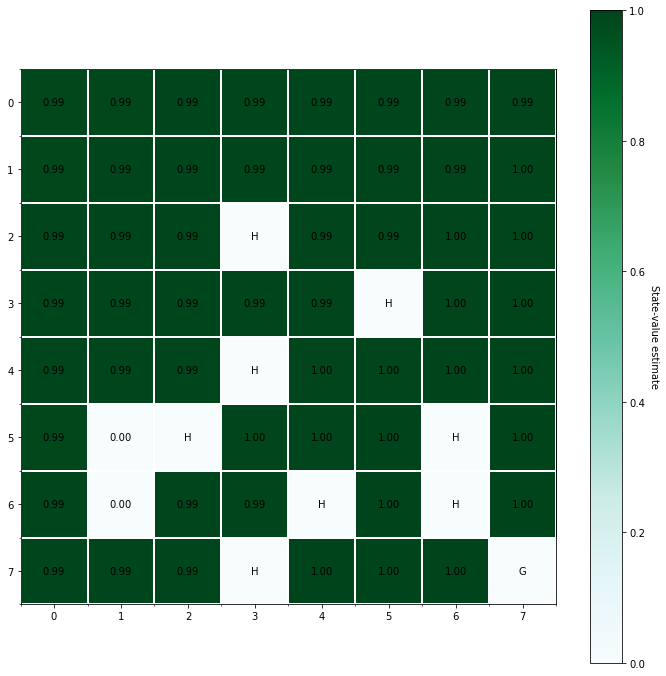

[0.5, 0.54, 0.5800000000000001, 0.6200000000000001, 0.6600000000000001, 0.7000000000000002, 0.7400000000000002, 0.7800000000000002, 0.8200000000000003, 0.8600000000000003, 0.9000000000000004, 0.9400000000000004, 0.9800000000000004]
2.363905191421509


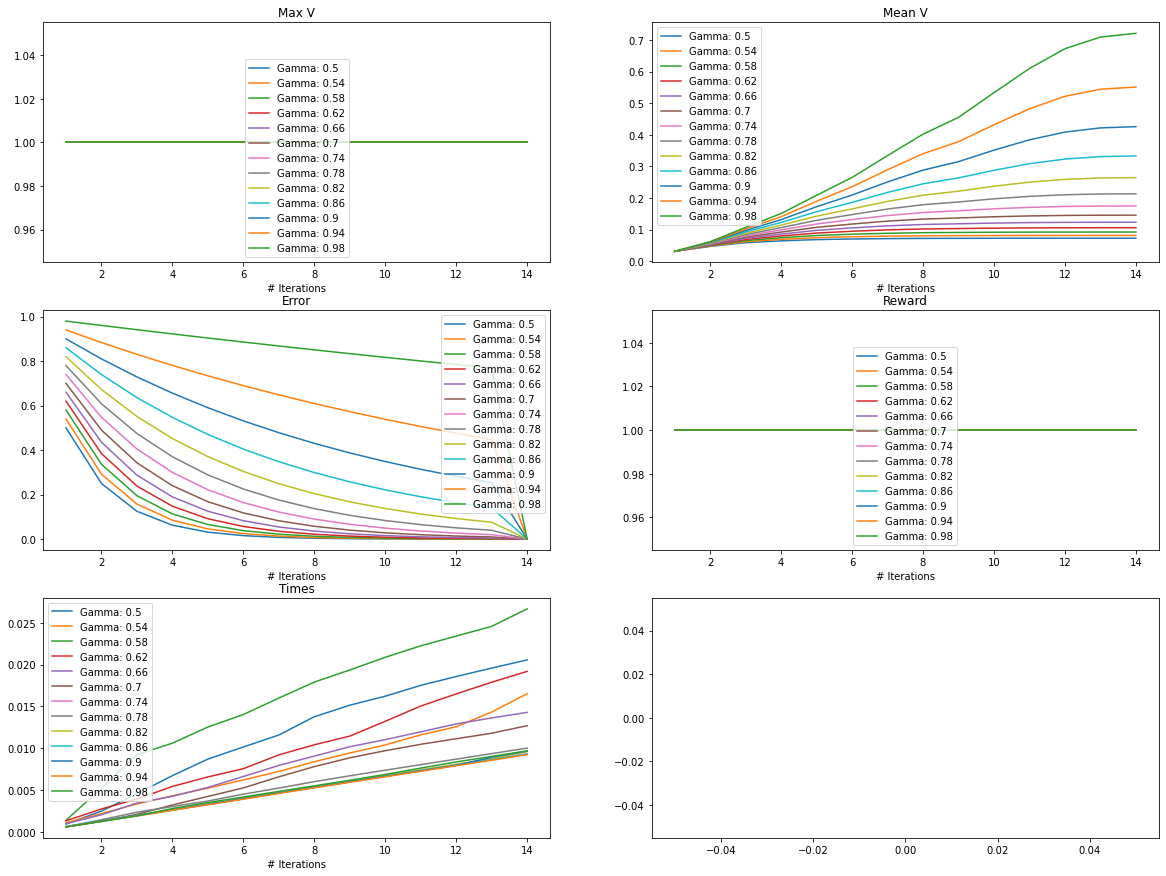

In [118]:
tic = time()
env = gym.make("FrozenLake-v1", is_slippery=False, desc=MAPS["8x8"])
r, p = getRewardProb(env,8)
vi = mdp.PolicyIteration(p, r, 0.999, max_iter=500)
vi.run()
visualize_policy(vi.policy, (8,8), "8x8")
visualize_value(vi.V, (8,8), "8x8")
valueIterateGraph(p, r, False)
print(time()-tic)

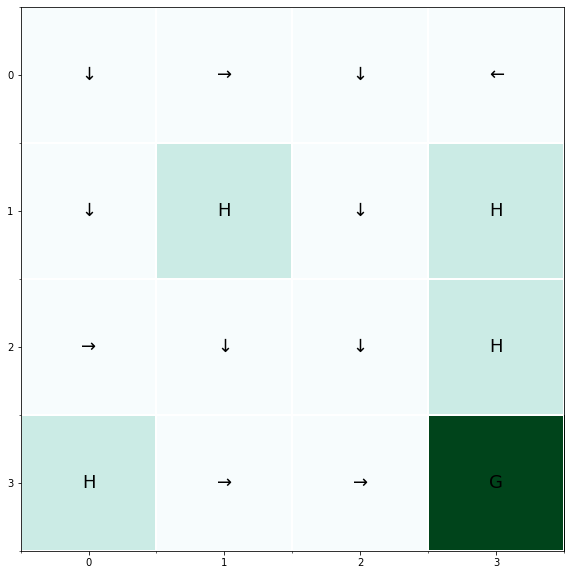

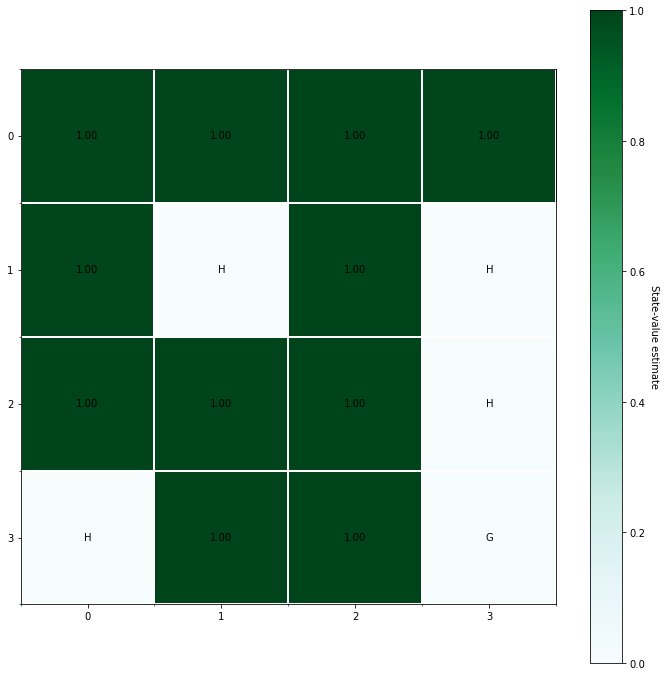

[0.5, 0.54, 0.5800000000000001, 0.6200000000000001, 0.6600000000000001, 0.7000000000000002, 0.7400000000000002, 0.7800000000000002, 0.8200000000000003, 0.8600000000000003, 0.9000000000000004, 0.9400000000000004, 0.9800000000000004]
1.5535690784454346


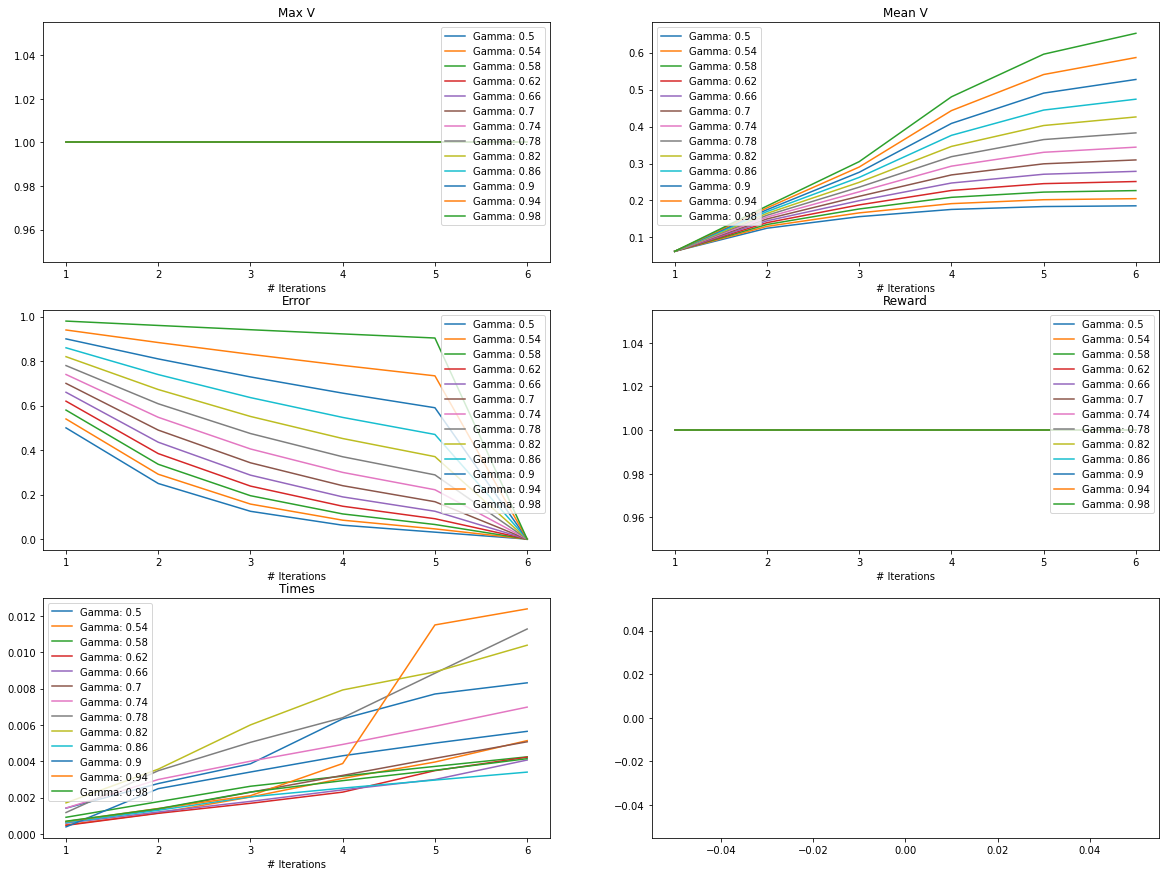

In [119]:
tic = time()
env = gym.make("FrozenLake-v1", is_slippery=False, desc=MAPS["4x4"])
r, p = getRewardProb(env,4)
vi = mdp.PolicyIteration(p, r, 0.999, max_iter=500)
vi.run()
visualize_policy(vi.policy, (4,4), "4x4")
visualize_value(vi.V, (4,4), "4x4")
valueIterateGraph(p, r, False)
print(time()-tic)

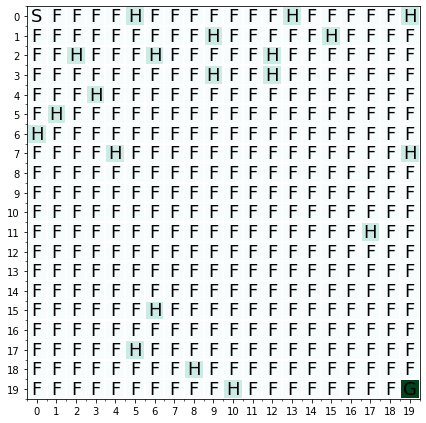

4.672631025314331
0.7094540596008301


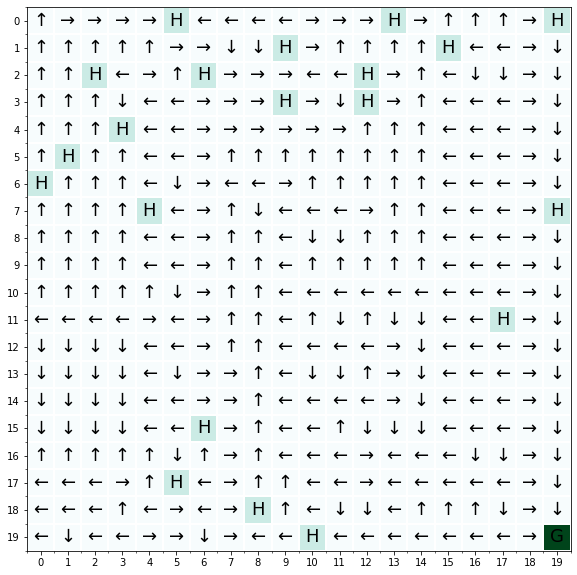

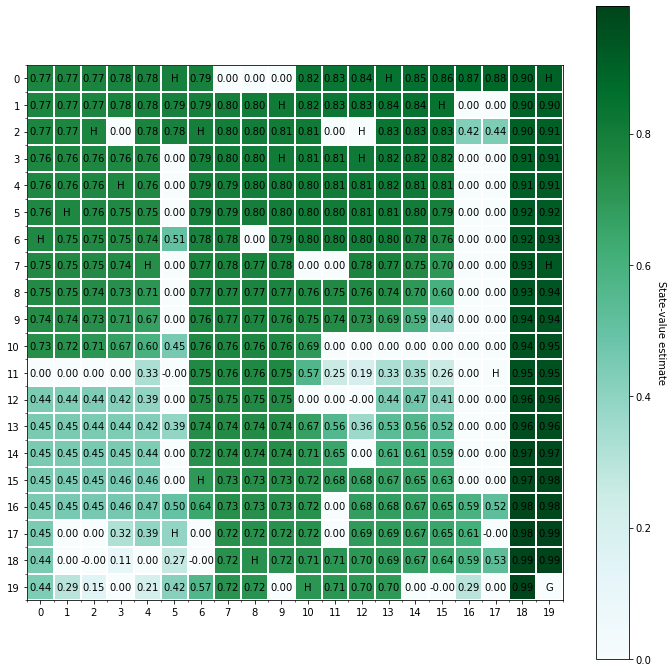

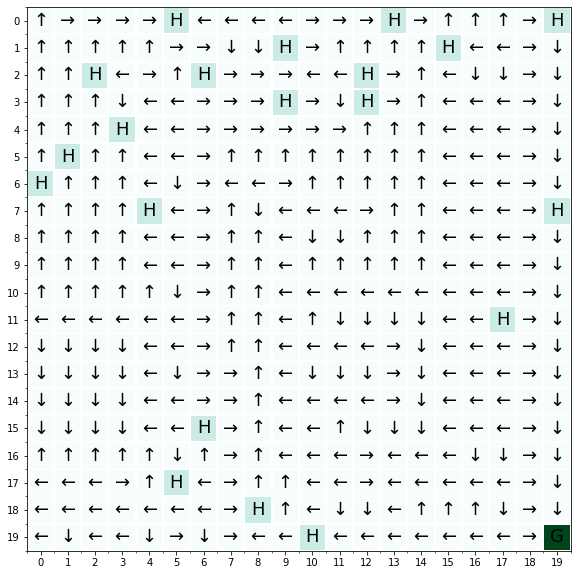

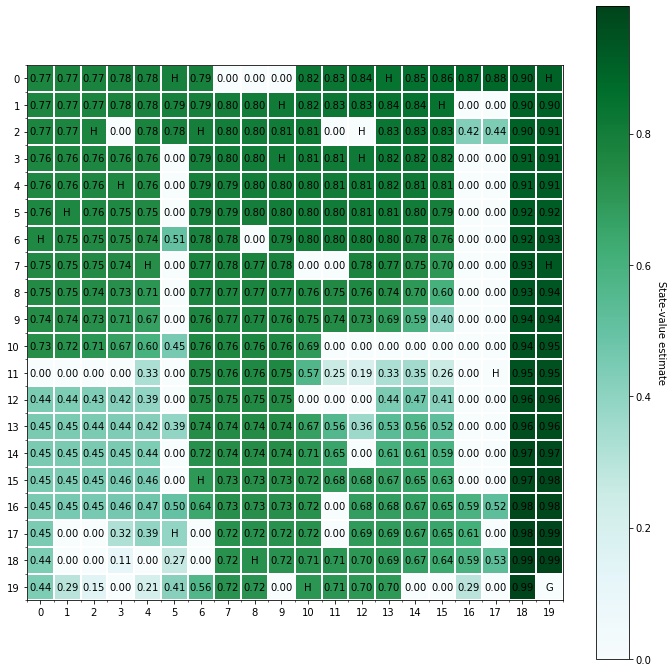

In [49]:
s = 20
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v1", map_name=None, desc=MAPS["20x20"])
env.reset()
visualize_env(env, opt)
r, p = getRewardProb(env, s)

tic = time()
vi1 = mdp.PolicyIteration(p, r, 0.999, max_iter=500)
vi1.run()
print(time()-tic)

tic = time()
vi2 = mdp.ValueIteration(p, r, 0.999, max_iter=5000)
vi2.run()
print(time()-tic)

visualize_policy(vi1.policy, sz, opt)
visualize_value(vi1.V, sz, opt)
visualize_policy(vi2.policy, sz, opt)
visualize_value(vi2.V, sz, opt)

In [50]:
print("Policies match {}%".format(100*(np.array(vi1.policy) == np.array(vi2.policy)).sum()/np.array(vi1.policy).shape[0]))

Policies match 98.5%


[0.5, 0.54, 0.5800000000000001, 0.6200000000000001, 0.6600000000000001, 0.7000000000000002, 0.7400000000000002, 0.7800000000000002, 0.8200000000000003, 0.8600000000000003, 0.9000000000000004, 0.9400000000000004, 0.9800000000000004]


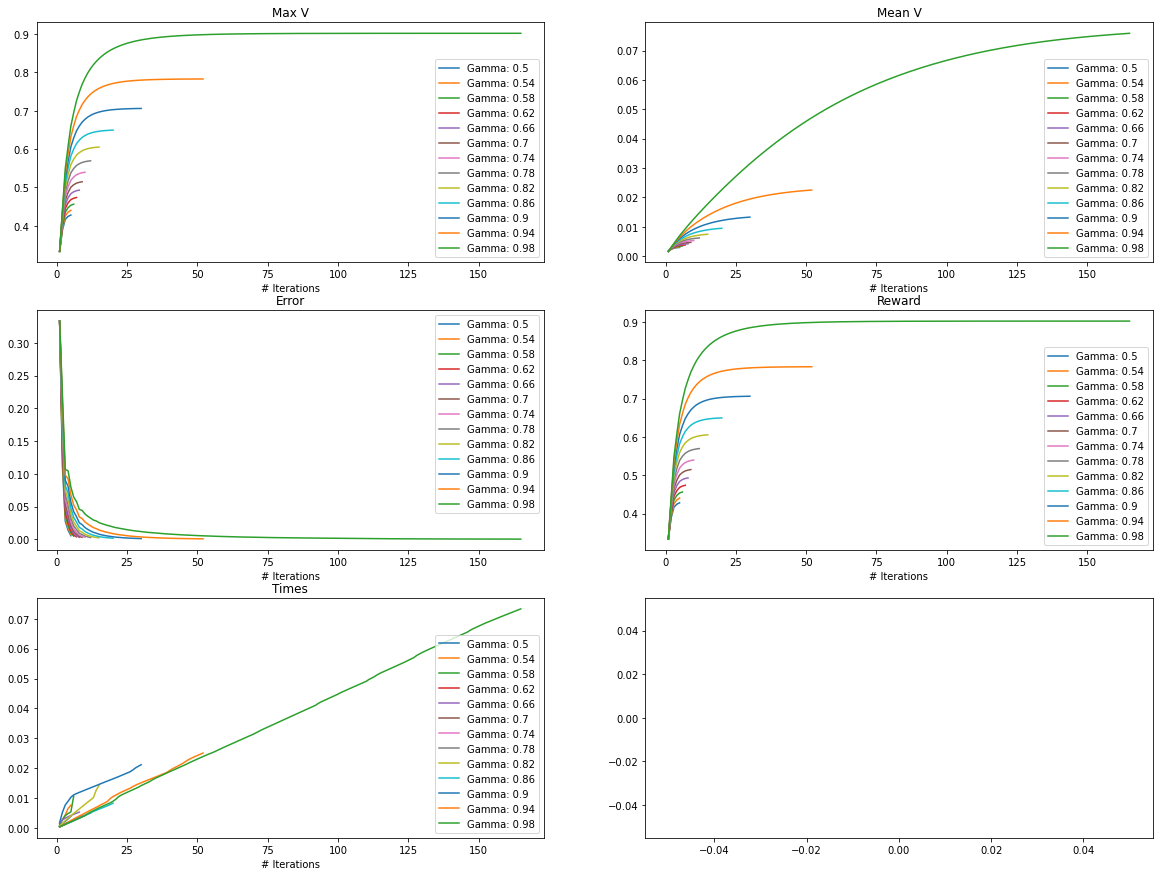

In [51]:
env = gym.make("FrozenLake-v1", is_slippery=True, map_name=None, desc=MAPS["20x20"])
r, p = getRewardProb(env,20)
valueIterateGraph(p, r)

[0.5, 0.54, 0.5800000000000001, 0.6200000000000001, 0.6600000000000001, 0.7000000000000002, 0.7400000000000002, 0.7800000000000002, 0.8200000000000003, 0.8600000000000003, 0.9000000000000004, 0.9400000000000004, 0.9800000000000004]
3.835447072982788


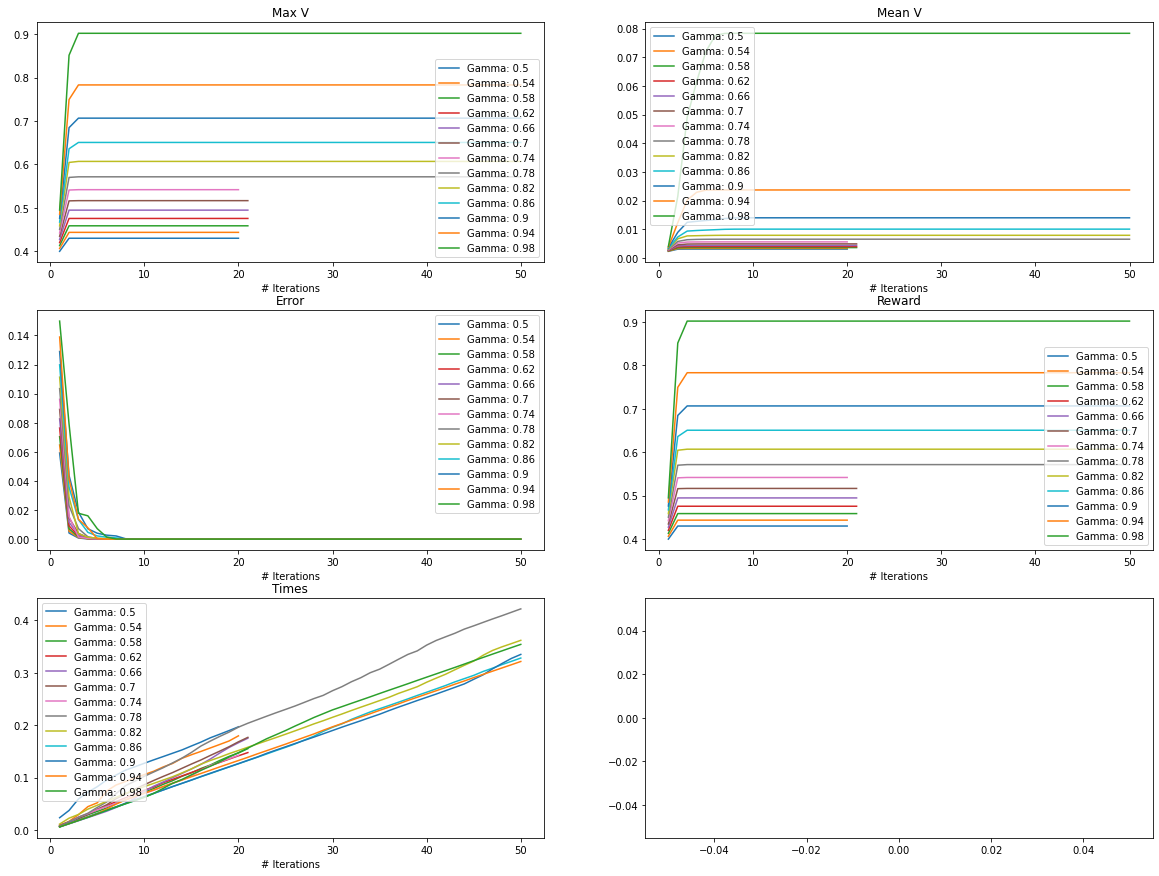

In [52]:
from time import time
tic = time()
env = gym.make("FrozenLake-v1", is_slippery=True, map_name=None, desc=MAPS["20x20"])
r, p = getRewardProb(env,20)
valueIterateGraph(p, r, False)
print(time()-tic)

## 3. Q-Learning 

True
33.52230405807495


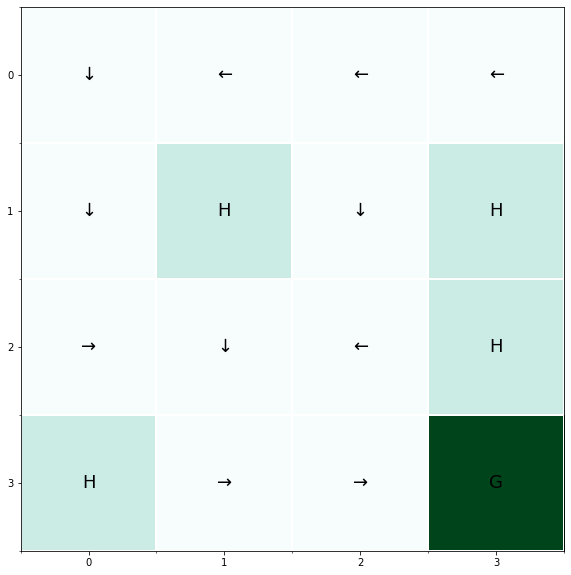

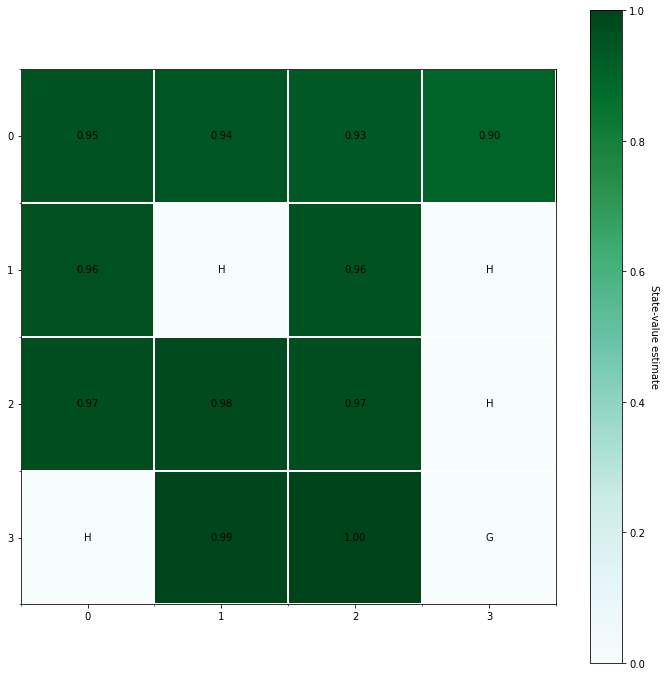

In [92]:
s = 4
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False)
env.reset()
r, p = getRewardProb(env, s)

tic = time()
vi2 = mdp.QLearning(p, r, gamma=0.99, alpha=0.1, alpha_decay=0.99999, epsilon=1, epsilon_decay=0.9999, n_iter=500000)
vi2.run()
expected = np.amax(vi2.Q, axis=1)
print(all(expected[k] - vi2.V[k] < 1e-12 for k in range(len(expected))))
print(time()-tic)

visualize_policy(vi2.policy, sz, opt)
visualize_value(vi2.V, sz, opt)

True
653.7101790904999


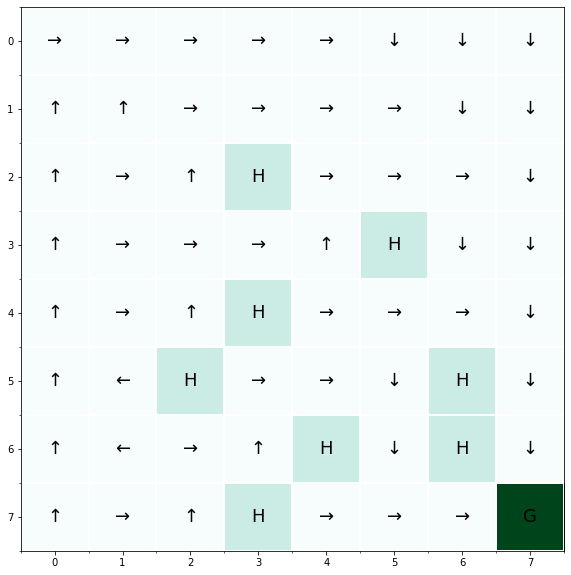

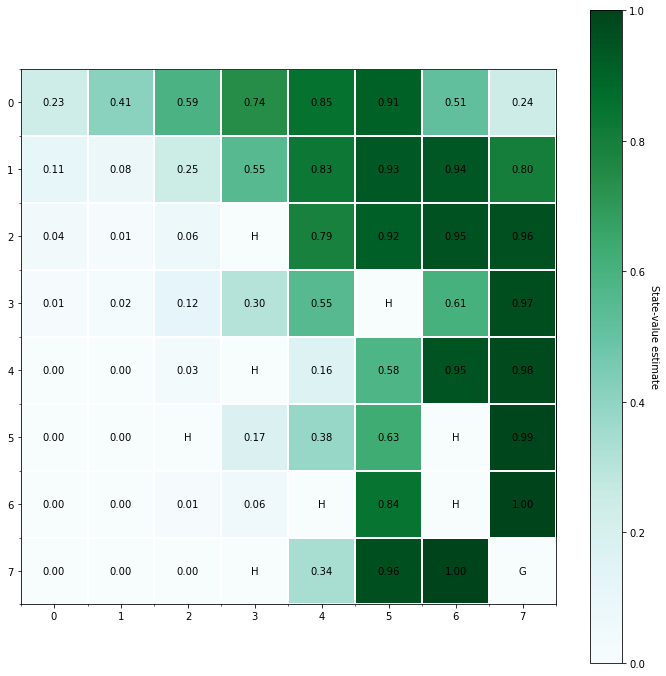

In [116]:
s = 8
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
env.reset()
r, p = getRewardProb(env, s)

tic = time()
vi2 = mdp.QLearning(p, r, gamma=0.99, alpha=0.1, alpha_decay=0.99999, epsilon=0.8, epsilon_decay=0.9999, n_iter=5000000)
vi2.run()
expected = np.amax(vi2.Q, axis=1)
print(all(expected[k] - vi2.V[k] < 1e-12 for k in range(len(expected))))
print(time()-tic)

visualize_policy(vi2.policy, sz, opt)
visualize_value(vi2.V, sz, opt)

42.07234191894531


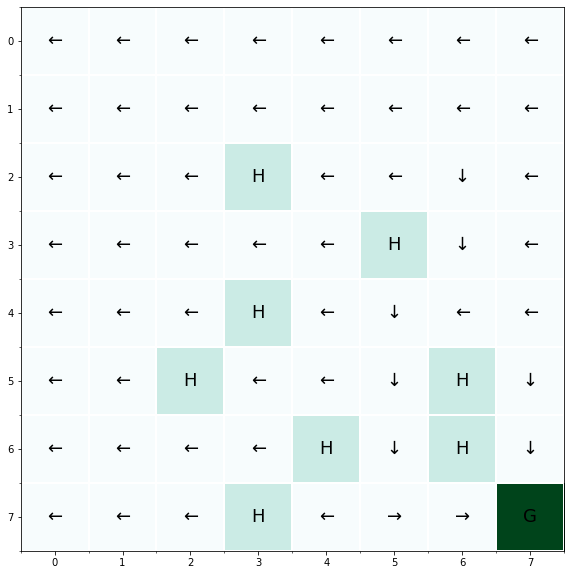

In [55]:
# s = 8
# opt = "{}x{}".format(s,s)
# sz = (s,s)
# env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
# env.reset()
# r, p = getRewardProb(env, s)

# tic = time()
# vi2 = mdp.QLearning(p, r, gamma=0.99, alpha=0.1, alpha_decay=0.99999, epsilon=0.2, epsilon_decay=0.9999, n_iter=500000)
# vi2.run()
# print(time()-tic)

# visualize_policy(vi2.policy, sz, opt)
# visualize_value(vi2.V, sz, opt)

True
2991.003903865814


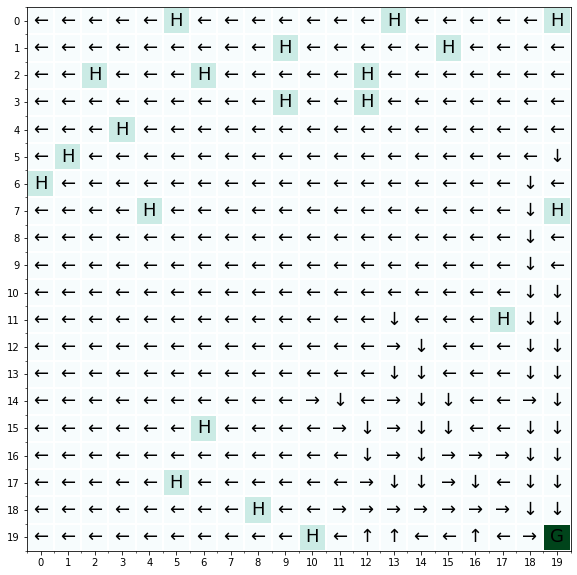

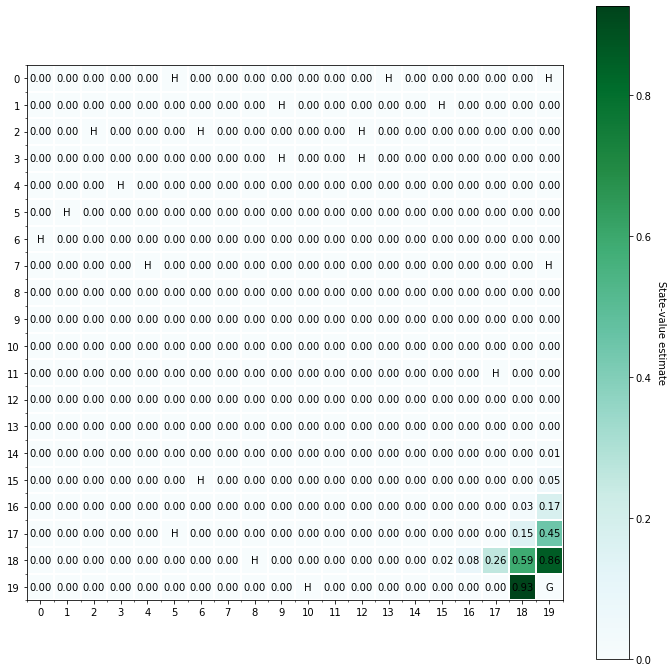

In [134]:
s = 20
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v1", map_name=None, is_slippery=False, desc=MAPS["20x20"])
env.reset()
r, p = getRewardProb(env, s)

tic = time()
vi2 = mdp.QLearning(p, r, gamma=0.8, alpha=0.1, alpha_decay=0.99999, epsilon=1, epsilon_decay=0.9999, n_iter=10000000)
vi2.run()
expected = np.amax(vi2.Q, axis=1)
print(all(expected[k] - vi2.V[k] < 1e-12 for k in range(len(expected))))
print(time()-tic)

visualize_policy(vi2.policy, sz, opt)
visualize_value(vi2.V, sz, opt)

In [80]:
def QLearnGraphGammas(p, r):
    max_vs = []
    mean_vs = []
    errors = []
    rewards = []
    times = []
    iterations = []
    gammas = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]
    for gamma in gammas:
        vi = mdp.QLearning(p, r, gamma=gamma, alpha=0.1, alpha_decay=0.99999, epsilon=1, epsilon_decay=0.9999, n_iter=600000)
        vi.run()
        expected = np.amax(vi.Q, axis=1)
        all(expected[k] - vi.V[k] < 1e-12 for k in range(len(expected)))
        vi.run_stats
        iterations.append(list(range(1,len(vi.run_stats)+1)))
        max_vs.append([el['Max V'] for el in vi.run_stats])
        mean_vs.append([el['Mean V'] for el in vi.run_stats])
        errors.append([el['Error'] for el in vi.run_stats])
        rewards.append([el['Reward'] for el in vi.run_stats])
        times.append([el['Time'] for el in vi.run_stats])

    f, ax = plt.subplots(3,2, figsize=(20,15))
    ax[0][0].set_title("Max V", fontsize=12)
    for i in range(len(max_vs)):
        ax[0][0].plot(iterations[i], max_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][0].legend()
    ax[0][0].set_xlabel("# Iterations")

    ax[0][1].set_title("Mean V", fontsize=12)
    for i in range(len(mean_vs)):
        ax[0][1].plot(iterations[i], mean_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][1].legend()
    ax[0][1].set_xlabel("# Iterations")

    ax[1][0].set_title("Error", fontsize=12)
    for i in range(len(errors)):
        ax[1][0].plot(iterations[i], errors[i], 'o', alpha=0.5, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][0].legend()
    ax[1][0].set_xlabel("# Iterations")

    ax[1][1].set_title("Reward", fontsize=12)
    for i in range(len(rewards)):
        ax[1][1].plot(iterations[i], rewards[i], 'o', alpha=0.5, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][1].legend()
    ax[1][1].set_xlabel("# Iterations")

    ax[2][0].set_title("Times", fontsize=12)
    for i in range(len(max_vs)):
        ax[2][0].plot(iterations[i], rewards[i], 'o', alpha=0.5, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[2][0].legend()
    ax[2][0].set_xlabel("# Iterations")
    
    plt.plot()
    
def QLearnGraphEpsilons(p, r):
    max_vs = []
    mean_vs = []
    errors = []
    rewards = []
    times = []
    iterations = []
    epsilons = [0, 0.2, 0.4, 0.6, 0.8, 1]
    for epsilon in epsilons:
        vi = mdp.QLearning(p, r, gamma=0.9, alpha=0.1, alpha_decay=0.99999, epsilon=epsilon, epsilon_decay=0.9999, n_iter=500000)
        vi.run()
        vi.run_stats
        iterations.append(list(range(1,len(vi.run_stats)+1)))
        max_vs.append([el['Max V'] for el in vi.run_stats])
        mean_vs.append([el['Mean V'] for el in vi.run_stats])
        errors.append([el['Error'] for el in vi.run_stats])
        rewards.append([el['Reward'] for el in vi.run_stats])
        times.append([el['Time'] for el in vi.run_stats])

    f, ax = plt.subplots(3,2, figsize=(20,15))
    ax[0][0].set_title("Max V", fontsize=12)
    for i in range(len(max_vs)):
        ax[0][0].plot(iterations[i], max_vs[i], alpha=1, label="epsilon: {}".format(np.round(epsilons[i],3)))
    ax[0][0].legend()
    ax[0][0].set_xlabel("# Iterations")

    ax[0][1].set_title("Mean V", fontsize=12)
    for i in range(len(mean_vs)):
        ax[0][1].plot(iterations[i], mean_vs[i], alpha=1, label="epsilon: {}".format(np.round(epsilons[i],3)))
    ax[0][1].legend()
    ax[0][1].set_xlabel("# Iterations")

    ax[1][0].set_title("Error", fontsize=12)
    for i in range(len(errors)):
        ax[1][0].plot(iterations[i], errors[i], 'o', alpha=1, label="epsilon: {}".format(np.round(epsilons[i],3)))
    ax[1][0].legend()
    ax[1][0].set_xlabel("# Iterations")

    ax[1][1].set_title("Reward", fontsize=12)
    for i in range(len(rewards)):
        ax[1][1].plot(iterations[i], rewards[i], 'o', alpha=1, label="epsilon: {}".format(np.round(epsilons[i],3)))
    ax[1][1].legend()
    ax[1][1].set_xlabel("# Iterations")
    
    ax[2][0].set_title("Times", fontsize=12)
    for i in range(len(times)):
        ax[2][0].plot(iterations[i], times[i], 'o', alpha=1, label="epsilon: {}".format(np.round(epsilons[i],3)))
    ax[2][0].legend()
    ax[2][0].set_xlabel("# Iterations")
    
    plt.plot()

In [81]:
s = 8
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
env.reset()
r, p = getRewardProb(env, s)

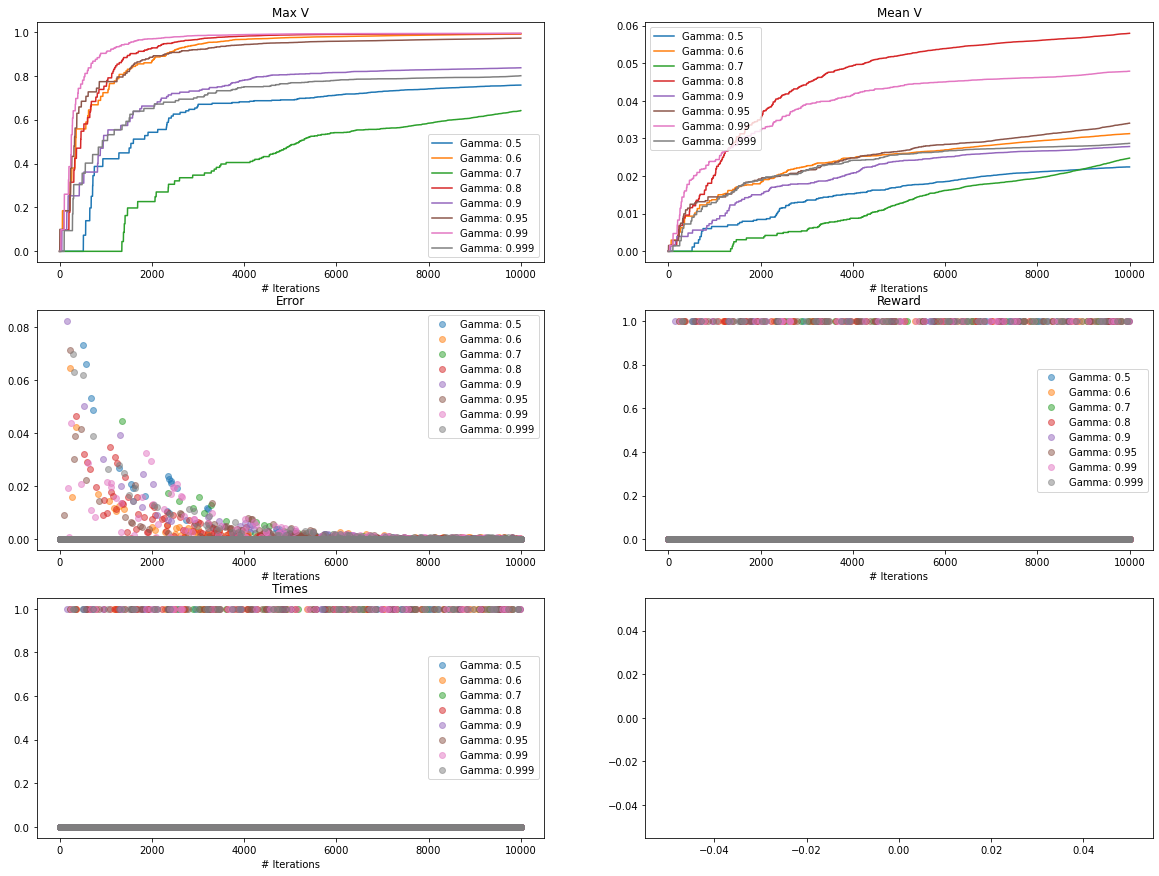

In [82]:
QLearnGraphGammas(p, r)

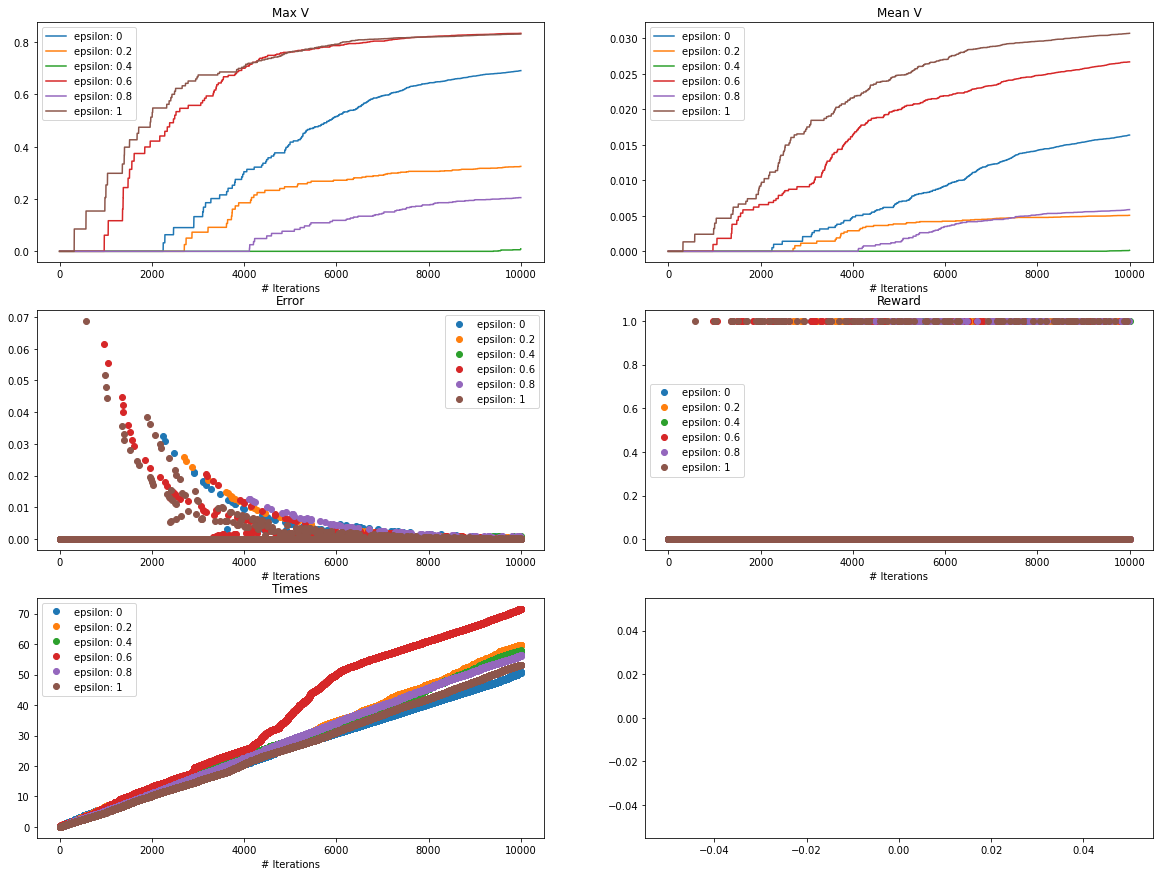

In [83]:
QLearnGraphEpsilons(p, r)

In [108]:
s = 20
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v1", map_name=None, is_slippery=False, desc=MAPS["20x20"])
env.reset()
r, p = getRewardProb(env, s)

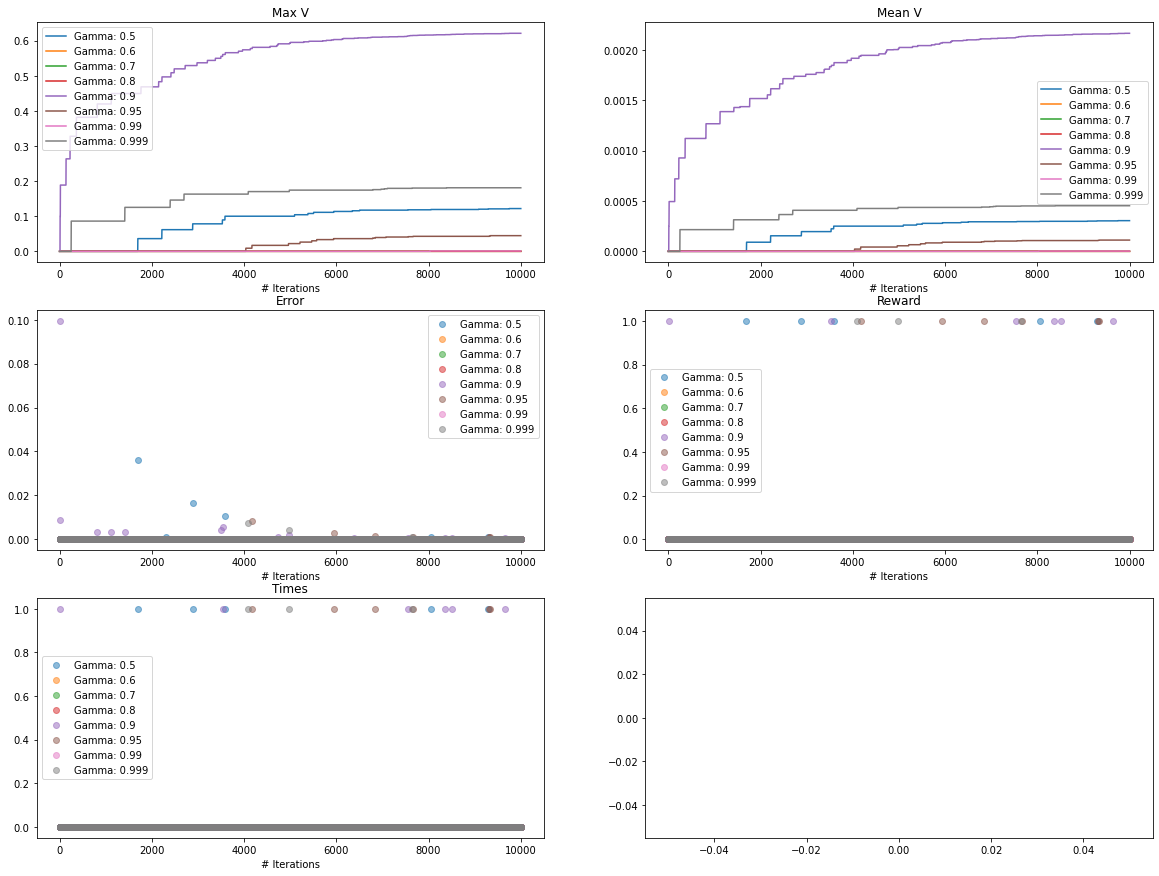

In [109]:
QLearnGraphGammas(p, r)

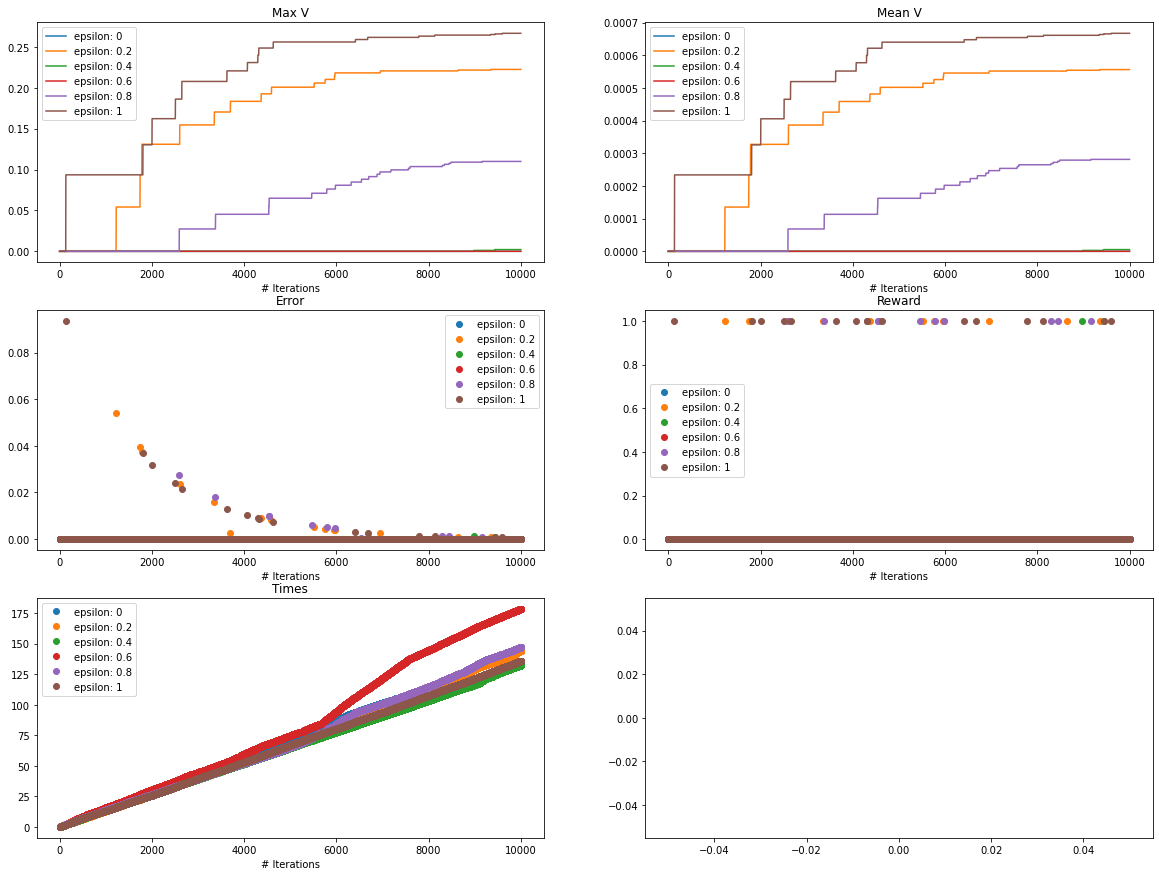

In [110]:
QLearnGraphEpsilons(p, r)

# Problem 2 - Hanoi Towers 

In [123]:
pip install -i https://pypi.tuna.tsinghua.edu.cn/simple gym==0.21.0

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 1.5 MB 198 kB/s eta 0:00:01
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616823 sha256=2d3dcaa1e6bdcc6c3b3d1f83f9024ff50981993187e882ad3443102d30799706
  Stored in directory: /Users/zj88zj/Library/Caches/pip/wheels/7c/70/14/df78d64ec823d37f98495d29f8bb3007eb6530618c612624e2
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.26.2
    Uninstalling gym-0.26.2:
      Successfully uninstalled gym-0.26.2
Note: you may need to restart the kernel to use updated packages.


In [124]:
import sys
from contextlib import closing
from six import StringIO, b
from gym import utils
from gym.envs.toy_text import discrete
import random
from toh_gym.envs import TohEnv


class TohEnv(discrete.DiscreteEnv):
    metadata = {'render.modes': ['human', 'ansi']}

    def apply_action(self, s, a):
        s = [list(i) for i in s]
        if len(s[a[0]]) == 0:
            # Invalid move
            return None
        to_move = s[a[0]][-1]
        source = a[0]
        dest = a[1]
        new_state = s[:]
        new_state[source].pop()
        new_state[dest].append(to_move)
        output = tuple([tuple(i) for i in new_state])
        return output

    def is_state_valid(self, s):
        s = [list(i) for i in s]
        for i in s:
            if i != sorted(i, reverse=True):
                return False
        return True

    def generate_all_states(self, initial_state):
        states = []
        states.append(initial_state)

        while True:
            old_len = len(states)
            for s in states:
                for action in self.action_list:
                    new_state = self.apply_action(s, action)
                    if new_state and new_state not in states:
                        if self.is_state_valid(new_state):
                            states.append(new_state)
            new_len = len(states)
            if old_len == new_len:
                break
        return states

    def __init__(self, initial_state=((2, 1, 0), (), ()), goal_state=((), (), (2, 1, 0)), noise=0):

        self.initial_state = initial_state
        assert noise < 1.0, "noise must be between 0 and 1"
        self.goal_state = goal_state

        self.action_list = [(0, 1), (0, 2), (1, 0),
                            (1, 2), (2, 0), (2, 1)]

        self.all_states = self.generate_all_states(initial_state)

        self.nS = len(self.all_states)
        self.nA = len(self.action_list)

        # Maintaining mappings to make use of algorithms from frozen lake.
        # Used to get a state by index of an array instead of a tuple
        self.state_mapping = {}
        self.inverse_mapping = {}
        for i in range(len(self.all_states)):
            self.state_mapping[i] = self.all_states[i]
            self.inverse_mapping[self.all_states[i]] = i

        ## Generating probability matrix
        self.P = {s: {a: [] for a in range(len(self.action_list))}
                  for s in range(len(self.all_states))}

        # For stochastic environment
        self.noise = noise
        for s in range(len(self.all_states)):
            for a in range(len(self.action_list)):
                li = self.P[s][a]
                if self.state_mapping[s] == self.goal_state:
                    li.append((1, s, 0, True))
                else:
                    if noise == 0:
                        done = False
                        new_state = self.apply_action(
                            self.state_mapping[s], self.action_list[a])
                        rew = 0
                        if new_state == None:
                            new_state = self.state_mapping[s]
                        if self.is_state_valid(new_state) == False:
                            new_state = self.state_mapping[s]
                            done = True
                        if new_state == self.goal_state:
                            rew = 100
                            done = True
                        li.append(
                            (1, self.inverse_mapping[new_state], rew, done))
                    else:
                        for b in [(a, 1-noise), (random.choice(range(6)), noise)]:
                            a, prob = b[0], b[1]
                            done = False
                            new_state = self.apply_action(
                                self.state_mapping[s], self.action_list[a])
                            rew = 0
                            if new_state == None:
                                new_state = self.state_mapping[s]
                            if self.is_state_valid(new_state) == False:
                                new_state = self.state_mapping[s]
                                done = True
                            if new_state == self.goal_state:
                                rew = 100
                                done = True
                            li.append(
                                (prob, self.inverse_mapping[new_state], rew, done))

        self.isd = np.array([self.is_state_valid(self.state_mapping[s])
                             for s in range(len(self.all_states))]).astype('float').ravel()
        self.isd /= self.isd.sum()

        super(TohEnv, self).__init__(self.nS, self.nA, self.P, self.isd)

In [125]:
def runEpisodes(episodes, gamma, max_iter, R, p, n, use_vi=True, qlearn=False, epsilon=0.8):
#     (50, gamma, max_iter, r, p, n)
    n_steps = []
    successes = 0
    for episode in range(episodes):
        env = TohEnv(poles=int(p), rings=int(R), noise=n)
        env = TohEnv(initial_state=((2, 1, 0), (), ()), goal_state=((), (), (2, 1, 0), noise=n)
        env.reset()
        t, r = getRewardProb(env)
        try:
            if use_vi:
                vi = mdp.ValueIteration(t, r, gamma)
            elif use_vi and not qlearn:
                vi = mdp.PolicyIteration(t,r, gamma)
            else:
                vi = mdp.QLearning(t, r, gamma=gamma, alpha=0.1, alpha_decay=0.9999, epsilon=epsilon, epsilon_decay=0.99, n_iter=11000)
        except OverflowError as e:
            continue
        vi.run()
        done = False
        state = 0
        policy = vi.policy
        t = 0
        while not done:
            action = policy[state]
            state, reward, done, info = env.step(action)
            if done:
                n_steps.append(t)
                successes += 1
                break
            if t==10000:
                n_steps.append(10000)
                break
            t += 1
    return sum(n_steps)/len(n_steps), successes/episodes

In [126]:
def valueIterateGraph(p, r, value_iterate=True):
    max_vs = []
    mean_vs = []
    errors = []
    rewards = []
    iterations = []
    gammas = list(np.arange(0.5,1,0.04))
    print(gammas)
    for gamma in gammas:
        if value_iterate:
            vi = mdp.ValueIteration(p, r, gamma)
        else:
            vi = mdp.PolicyIteration(p, r, gamma, max_iter=50)
        vi.run()
        vi.run_stats
        iterations.append(list(range(1,len(vi.run_stats)+1)))
        max_vs.append([el['Max V'] for el in vi.run_stats])
        mean_vs.append([el['Mean V'] for el in vi.run_stats])
        print(mean_vs)
        errors.append([el['Error'] for el in vi.run_stats])
        rewards.append([el['Reward'] for el in vi.run_stats])

    f, ax = plt.subplots(2,2, figsize=(15,12))
    ax[0][0].set_title("Max V", fontsize=16)
    for i in range(len(max_vs)):
        ax[0][0].plot(iterations[i], max_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][0].legend()
    ax[0][0].set_xlabel("# Iterations")

    ax[0][1].set_title("Mean V", fontsize=16)
    for i in range(len(mean_vs)):
        ax[0][1].plot(iterations[i], mean_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][1].legend()
    ax[0][1].set_xlabel("# Iterations")

    ax[1][0].set_title("Error", fontsize=16)
    for i in range(len(errors)):
        ax[1][0].plot(iterations[i], errors[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][0].legend()
    ax[1][0].set_xlabel("# Iterations")

    ax[1][1].set_title("Reward", fontsize=16)
    for i in range(len(max_vs)):
        ax[1][1].plot(iterations[i], rewards[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][1].legend()
    ax[1][1].set_xlabel("# Iterations")
    plt.plot()

In [127]:
# Unpacked from gym.unwrapped.P is a list of states. Each state has a dictionary [0,1,2,3]. Each dictionary
# contains a 4 part tuple [probability(?),new_state,reward,finished]
def getRewardProb(env):
    n_a, n_s = env.nA, env.nS
    t = np.zeros([n_a, n_s, n_s])
    r = np.zeros([n_s, n_a])
    for state in range(n_s):
        for action in range(n_a):
            for p_trans, next_state, reward, _ in env.P[state][action]:
                t[action,state,next_state] += p_trans
                r[state,action] = reward
            t[action,state,:] = t[action,state,:] / np.sum(t[action,state,:])
    return t, r

## Value Iteration

In [ ]:
gammas_5r_3p_0n = [el/100 for el in range(1,100,5)]
n_steps_5r_3p_0n = []
success_rates_5r_3p_0n = []
r =5
p =3
n =.2
max_iter= 5000
for gamma in tqdm(gammas_5r_3p_0n):
    avg_steps, success_rate = runEpisodes(50, gamma, max_iter, r, p, n)
    n_steps_5r_3p_0n.append(avg_steps)
    success_rates_5r_3p_0n.append(success_rate)

In [ ]:
gammas_3r_3p_0n = [el/100 for el in range(1,100,5)]
n_steps_3r_3p_0n = []
success_rates_3r_3p_0n = []
r, p, n = 3, 3, 0
max_iter=5000
for gamma in tqdm(gammas):
    avg_steps, success_rate = runEpisodes(50, gamma, max_iter, r, p, n)
    n_steps_3r_3p_0n.append(avg_steps)
    success_rates_3r_3p_0n.append(success_rate)

In [ ]:
gammas_3r_3p_2n = [el/100 for el in range(1,100,5)]
n_steps_3r_3p_2n = []
success_rates_3r_3p_2n = []
r, p, n = 3, 3, 0.2
max_iter=5000
for gamma in tqdm(gammas):
    avg_steps, success_rate = runEpisodes(10, gamma, max_iter, r, p, n)
    n_steps_3r_3p_2n.append(avg_steps)
    success_rates_3r_3p_2n.append(success_rate)

In [ ]:
gammas_7r_4p_2n = [el/100 for el in range(1,100,5)]
n_steps_7r_4p_2n = []
success_rates_7r_4p_2n = []
r, p, n = 6, 3, 0.2
max_iter=5000
for gamma in tqdm(gammas):
    avg_steps, success_rate = runEpisodes(10, gamma, max_iter, r, p, n)
    n_steps_7r_4p_2n.append(avg_steps)
    success_rates_7r_4p_2n.append(success_rate)

In [ ]:
f, ax = plt.subplots(2, figsize=(10,10))
ax[0].set_title("Success Rate", fontsize=16)
ax[0].plot(gammas_5r_3p_0n, success_rates_5r_3p_0n, label="5 Rings, 3 poles, 2 Noise",linewidth=4)
ax[0].plot(gammas_3r_3p_0n, success_rates_3r_3p_0n, label="3 Rings, 3 poles, 0 Noise",linewidth=4)
ax[0].plot(gammas_3r_3p_2n, success_rates_3r_3p_2n, label="3 Rings, 3 poles, .2 Noise",linewidth=4, color='black')
ax[0].plot(gammas_7r_4p_2n, success_rates_7r_4p_2n, label="6 Rings, 3 poles, .2 Noise",linewidth=4, color='gray')
ax[0].tick_params(bottom=False)
ax[0].legend()
ax[0].set_xlabel("Gamma")

ax[1].set_title("Average # Steps to Successful Episode", fontsize=16)
ax[1].plot(gammas_5r_3p_0n[-10:], n_steps_5r_3p_0n[-8:], label="5 Rings, 3 poles, 2 Noise",linewidth=4)
ax[1].plot(gammas_3r_3p_0n[-10:], n_steps_3r_3p_0n[-10:], label="3 Rings, 3 poles, 0 Noise",linewidth=4)
ax[1].plot(gammas_3r_3p_2n[-9:], n_steps_3r_3p_2n[-9:], label="3 Rings, 3 poles, .2 Noise",linewidth=4, color='black')
ax[1].plot(gammas_7r_4p_2n[-9:], n_steps_7r_4p_2n[-9:], label="6 Rings, 3 poles, .2 Noise",linewidth=4, color='gray')
ax[1].tick_params(bottom=False)
ax[1].legend()
ax[1].set_xlabel("Gamma")

In [ ]:
env.render()

In [ ]:
env = TohEnv(poles=3, rings=5, noise=0.2)
env.reset()
t, r = getRewardProb(env)
valueIterateGraph(t, r)

## Policy iteration

In [ ]:
env = TohEnv(poles=3, rings=5, noise=0.2)
env.reset()
t, r = getRewardProb(env)
valueIterateGraph(t, r, value_iterate=False)

In [ ]:
Rs = [2,3,4,5,6]
Ps = [3,4,5]
converge_times = np.zeros((2, len(Rs), len(Ps)))
for i, value_iterate in enumerate([True, False]):
    for j,R in enumerate(Rs):
        for k,P in enumerate(Ps):
            tic = time()
            print(P,R)
            env = TohEnv(poles=P, rings=R, noise=0.2)
            env.reset()
            t, r = getRewardProb(env)
            vi = mdp.PolicyIteration(t, r, 0.9, max_iter=50)
            print(i,j,k)
            converge_times[i,j,k] = time()-tic
print(converge_times)

In [ ]:
converge_times = np.round(converge_times, 3)

In [ ]:
def plot1(axis):
    f, ax = plt.subplots(1, figsize=(10,10))
    im = ax.imshow(converge_times[axis].transpose())

    ax.set_xticks(np.arange(len(Rs)))
    ax.set_yticks(np.arange(len(Ps)))
    ax.set_xticklabels(Rs,size=15)
    ax.set_yticklabels(Ps,size=15)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    for i in range(len(Ps)):
        for j in range(len(Rs)):
            text = ax.text(j, i, converge_times[axis, j, i],
                           ha="center", va="center", color="w",size=16)
    if axis==0:
        ax.set_title("Value Iteration - Convergence Time (seconds)",size=18)
    else:
        ax.set_title("Policy Iteration - Convergence Time (seconds)",size=18)

    ax.set_xlabel("# Rings", size=16)
    ax.set_ylabel("# Poles", size=16)
    plt.show()
plot1(0)
plot1(1)

In [ ]:
gammas_5r_3p_0n = [el/100 for el in range(1,100,5)]
n_steps_5r_3p_0n = []
success_rates_5r_3p_0n = []
r =5
p =3
n =0
max_iter= 5000
for gamma in tqdm(gammas):
    avg_steps, success_rate = runEpisodes(50, gamma, max_iter, r, p, n, use_vi=False)
    n_steps_5r_3p_0n.append(avg_steps)
    success_rates_5r_3p_0n.append(success_rate)

gammas_3r_3p_0n = [el/100 for el in range(1,100,5)]
n_steps_3r_3p_0n = []
success_rates_3r_3p_0n = []
r, p, n = 3, 3, 0
max_iter=5000
for gamma in tqdm(gammas):
    avg_steps, success_rate = runEpisodes(50, gamma, max_iter, r, p, n, use_vi=False)
    n_steps_3r_3p_0n.append(avg_steps)
    success_rates_3r_3p_0n.append(success_rate)
    
gammas_3r_3p_2n = [el/100 for el in range(1,100,5)]
n_steps_3r_3p_2n = []
success_rates_3r_3p_2n = []
r, p, n = 3, 3, 0.2
max_iter=5000
for gamma in tqdm(gammas):
    avg_steps, success_rate = runEpisodes(10, gamma, max_iter, r, p, n, use_vi=False)
    n_steps_3r_3p_2n.append(avg_steps)
    success_rates_3r_3p_2n.append(success_rate)

gammas_7r_4p_2n = [el/100 for el in range(1,100,5)]
n_steps_7r_4p_2n = []
success_rates_7r_4p_2n = []
r, p, n = 6, 3, 0.2
max_iter=5000
for gamma in tqdm(gammas):
    avg_steps, success_rate = runEpisodes(10, gamma, max_iter, r, p, n, use_vi=False)
    n_steps_7r_4p_2n.append(avg_steps)
    success_rates_7r_4p_2n.append(success_rate)

In [ ]:
f, ax = plt.subplots(2, figsize=(10,10))
ax[0].set_title("Success Rate", fontsize=16)
ax[0].plot(gammas_5r_3p_0n, success_rates_5r_3p_0n, label="5 Rings, 3 poles, 0 Noise",linewidth=4)
ax[0].plot(gammas_3r_3p_0n, success_rates_3r_3p_0n, label="3 Rings, 3 poles, 0 Noise",linewidth=4)
ax[0].plot(gammas_3r_3p_2n, success_rates_3r_3p_2n, label="3 Rings, 3 poles, .2 Noise",linewidth=4, color='black')
ax[0].plot(gammas_7r_4p_2n, success_rates_7r_4p_2n, label="6 Rings, 3 poles, .2 Noise",linewidth=4, color='gray')
ax[0].tick_params(bottom=False)
ax[0].legend()
ax[0].set_xlabel("Gamma")

ax[1].set_title("Average # Steps to Successful Episode", fontsize=16)
ax[1].plot(gammas_5r_3p_0n[-3:], n_steps_5r_3p_0n[-3:], label="5 Rings, 3 poles, 0 Noise",linewidth=4)
ax[1].plot(gammas_3r_3p_0n[-10:], n_steps_3r_3p_0n[-10:], label="3 Rings, 3 poles, 0 Noise",linewidth=4)
ax[1].plot(gammas_3r_3p_2n[-9:], n_steps_3r_3p_2n[-9:], label="3 Rings, 3 poles, .2 Noise",linewidth=4, color='black')
ax[1].plot(gammas_7r_4p_2n[-9:], n_steps_7r_4p_2n[-9:], label="6 Rings, 3 poles, .2 Noise",linewidth=4, color='gray')
ax[1].tick_params(bottom=False)
ax[1].legend()
ax[1].set_xlabel("Gamma")

## Q-learning

In [ ]:
Rs = [2,3,4,5,6]
Ps = [3,4,5]
converge_times = np.zeros((len(Rs), len(Ps)))
for j,R in enumerate(Rs):
    for k,P in enumerate(Ps):
        tic = time()
        print(P,R)
        env = TohEnv(poles=P, rings=R, noise=0.2)
        env.reset()
        t, r = getRewardProb(env)
        vi = mdp.QLearning(t, r, gamma=0.99, alpha=0.1, alpha_decay=0.99999, epsilon=1, epsilon_decay=0.9999, n_iter=50000)
        converge_times[j,k] = time()-tic
print(converge_times)

In [ ]:
converge_times = np.round(converge_times, 3)

In [ ]:
def plot2():
    f, ax = plt.subplots(1, figsize=(10,10))
    im = ax.imshow(converge_times.transpose())

    ax.set_xticks(np.arange(len(Rs)))
    ax.set_yticks(np.arange(len(Ps)))
    
    ax.set_xticklabels(Rs,size=15)
    ax.set_yticklabels(Ps,size=15)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    for i in range(len(Ps)):
        for j in range(len(Rs)):
            text = ax.text(j, i, converge_times[j, i],
                           ha="center", va="center", color="w",size=16)
    ax.set_title("Q Learning - Convergence Time (seconds)",size=18)

    ax.set_xlabel("# Rings", size=16)
    ax.set_ylabel("# Poles", size=16)
    plt.show()
plot2()

In [ ]:
def valueIterateGraph2(t, r):
    max_vs = []
    mean_vs = []
    errors = []
    rewards = []
    iterations = []
    epsilons = list(np.arange(0,1,0.04))
    for epsilon in tqdm(epsilons):
        vi = mdp.QLearning(t, r, gamma=0.9, alpha=0.1, alpha_decay=0.9999, epsilon=epsilon, epsilon_decay=0.99, n_iter=100000)
        vi.run()
        vi.run_stats
        iterations.append(list(range(1,len(vi.run_stats)+1)))
        max_vs.append([el['Max V'] for el in vi.run_stats])
        mean_vs.append([el['Mean V'] for el in vi.run_stats])
        errors.append([el['Error'] for el in vi.run_stats])
        rewards.append([el['Reward'] for el in vi.run_stats])

    f, ax = plt.subplots(2,2, figsize=(15,12))
    ax[0][0].set_title("Max V", fontsize=16)
    for i in range(len(max_vs)):
        ax[0][0].plot(iterations[i], max_vs[i], alpha=1, label="Epsilon: {}".format(np.round(epsilon[i],3)))
    ax[0][0].legend()
    ax[0][0].set_xlabel("# Iterations")

    ax[0][1].set_title("Mean V", fontsize=16)
    for i in range(len(mean_vs)):
        ax[0][1].plot(iterations[i], mean_vs[i], alpha=1, label="Epsilon: {}".format(np.round(epsilon[i],3)))
    ax[0][1].legend()
    ax[0][1].set_xlabel("# Iterations")

    ax[1][0].set_title("Error", fontsize=16)
    for i in range(len(errors)):
        ax[1][0].plot(iterations[i], errors[i], alpha=1, label="Epsilon: {}".format(np.round(epsilon[i],3)))
    ax[1][0].legend()
    ax[1][0].set_xlabel("# Iterations")

    ax[1][1].set_title("Reward", fontsize=16)
    for i in range(len(max_vs)):
        ax[1][1].plot(iterations[i], rewards[i], alpha=1, label="Epsilon: {}".format(np.round(epsilon[i],3)))
    ax[1][1].legend()
    ax[1][1].set_xlabel("# Iterations")
    plt.plot()

In [ ]:
env = TohEnv(poles=3, rings=3, noise=0.2)
env.reset()
t, r = getRewardProb(env)
valueIterateGraph2(t, r)

In [ ]:
epsilon_3r_3p_0n = [el/100 for el in range(1,100,5)]
n_steps_3r_3p_0n = []
success_rates_3r_3p_0n = []
r, p, n = 3, 3, 0
max_iter=5000
for epsilon in tqdm(epsilon_3r_3p_0n):
    avg_steps, success_rate = runEpisodes(50, 0.9, max_iter, r, p, n, use_vi=False, qlearn=True, epsilon=epsilon)
    n_steps_3r_3p_0n.append(avg_steps)
    success_rates_3r_3p_0n.append(success_rate)

In [ ]:
f, ax = plt.subplots(2, figsize=(10,10))
ax[0].set_title("Success Rate", fontsize=16)
ax[0].plot(epsilon_3r_3p_0n[-10:], success_rates_3r_3p_0n[-10:], label="3 Rings, 3 poles, 0 Noise",linewidth=4)
ax[0].tick_params(bottom=False)
ax[0].legend()
ax[0].set_xlabel("Gamma")

ax[1].set_title("Average # Steps to Successful Episode", fontsize=16)
ax[1].plot(epsilon_3r_3p_0n[-10:], n_steps_3r_3p_0n[-10:], label="3 Rings, 3 poles, 0 Noise",linewidth=4)
ax[1].tick_params(bottom=False)
ax[1].legend()
ax[1].set_xlabel("Gamma")